In [1]:
import os
import glob
import pandas as pd
import lpips
import math
import plotly.express as px
import numpy as np
from natsort import natsorted
import cv2
from PIL import Image
import torchvision.transforms as transforms
from tqdm import tqdm
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import scipy.stats
import matplotlib.pyplot as plt
import scipy.sparse as sp
from scipy.sparse.linalg import spsolve
from scipy.sparse.linalg import cg
from scipy.sparse.linalg import lsqr
from itertools import product
from tqdm import tqdm
import glob
from openpyxl import Workbook
from openpyxl.drawing.image import Image as Image_openpyxl
from openpyxl.utils import get_column_letter
from openpyxl.styles import Alignment
from openpyxl.drawing.xdr import XDRPositiveSize2D
from openpyxl.utils.units import pixels_to_EMU, cm_to_EMU
from openpyxl.drawing.spreadsheet_drawing import OneCellAnchor, AnchorMarker
import pickle
import plotly.graph_objects as go
import random
from fractions import Fraction

In [2]:
loss_fn_alex = lpips.LPIPS(net='alex')
loss_fn_vgg = lpips.LPIPS(net='vgg')

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/Users/ibk5106/anaconda3/envs/conda_pytorch/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/ibk5106/anaconda3/envs/conda_pytorch/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /Users/ibk5106/anaconda3/envs/conda_pytorch/lib/python3.8/site-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/Users/ibk5106/anaconda3/envs/conda_pytorch/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /Users/ibk5106/anaconda3/envs/conda_pytorch/lib/python3.8/site-packages/lpips/weights/v0.1/vgg.pth


In [3]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

transform_f = transforms.ToTensor()

def normalize_image(in_img):
    pixels = np.asarray(in_img).astype('float32')
    pixels = (pixels - mean) / std
    return pixels

In [4]:
limit_frame_count = -1
ROOT = os.path.abspath(os.path.join(os.curdir, '../'))

In [5]:
images_dir = os.path.join(ROOT, 'Dashboard Data/Images')
data_path = os.path.join(ROOT, 'Dashboard Data')
gt_fol = os.path.join(data_path, "GT_N")

In [6]:
def calculate_model_ap_ar_af1(gt_path, gt_files, pred_path, obj_list=None):
    gt_dict = {}
    pred_dict = {}

    for fl in gt_files:
        if fl in ["video-10-segment-1.csv", "video-9-segment-2.csv"]:
            continue
        gt_fl = os.path.join(gt_path, fl)
        pred_fl = os.path.join(pred_path, fl)

        if not os.path.exists(pred_fl):
            continue

        if obj_list:
            gt_data = pd.read_csv(gt_fl)
            if limit_frame_count > 0:
                if len(list(gt_data.columns)) > limit_frame_count:
                    gt_data = gt_data.iloc[: , :limit_frame_count]

            gt_data = gt_data.transpose()
            gt_data.columns = [x__.lower() for x__ in gt_data.iloc[0]]
            gt_data = gt_data.reindex(columns=obj_list).iloc[1:].transpose().reset_index()

            pred_data = pd.read_csv(pred_fl)
            if limit_frame_count > 0:
                if len(list(pred_data.columns)) > limit_frame_count:
                    pred_data = pred_data.iloc[: , :limit_frame_count]

            pred_data = pred_data.transpose()
            pred_data.columns = [x__.lower() for x__ in pred_data.iloc[0]]
            pred_data = pred_data.reindex(columns=obj_list).iloc[1:].transpose().reset_index()    
            # print(gt_data)
            # print(pred_data)
        else:
            gt_data = pd.read_csv(gt_fl)
            if limit_frame_count > 0:
                if len(list(gt_data.columns)) > limit_frame_count:
                    gt_data = gt_data.iloc[: , :limit_frame_count]
            gt_data.replace(-1, 1, inplace=True)
            pred_data = pd.read_csv(pred_fl)
            if limit_frame_count > 0:
                if len(list(pred_data.columns)) > limit_frame_count:
                    pred_data = pred_data.iloc[: , :limit_frame_count]
            pred_data.replace(-1, 1, inplace=True)
        
        x = []
        for index, row in gt_data.iterrows():
            # if list(row)[0].strip().lower() in ["Sidewalk pits"]:
            #     continue
            if list(row)[0].strip().lower() in gt_dict.keys():
                gt_dict[list(row)[0].strip().lower()] += list(row)[1:]
            else:
                gt_dict[list(row)[0].strip().lower()] = list(row)[1:]

            x.append(len(list(row)[1:]))

        y = []
        for index, row in pred_data.iterrows():
            # if list(row)[0].strip().lower() in ["Sidewalk pits"]:
            #     continue
            if list(row)[0].strip().lower() in pred_dict.keys():
                pred_dict[list(row)[0].strip().lower()] += list(row)[1:]
            else:
                pred_dict[list(row)[0].strip().lower()] = list(row)[1:]
            y.append(len(list(row)[1:]))

        if x != y:
            print(len(x), len(y), fl)

    target_array = []
    pred_array = []

    label_names = []

    for key in gt_dict.keys():
        if key in pred_dict.keys():
            if obj_list:
                if key not in obj_list:
                    continue
            if len(gt_dict[key]) == len(pred_dict[key]):
                target_array.append(gt_dict[key])
                pred_array.append(pred_dict[key])
                label_names.append(key)
            else:
                print(len(gt_dict[key]), len(pred_dict[key]), key)
    
    target_array = np.array(target_array).T
    pred_array = np.array(pred_array).T

    # print(target_array.shape)

    # try:
    if pred_path.endswith('GT_N'):
        precs = precision_score(target_array, pred_array, average="micro")
        recs = recall_score(target_array, pred_array, average="micro")
        f1ss = f1_score(target_array, pred_array, average="micro")
    else:
        precs = precision_score(target_array, pred_array, average="micro")
        recs = recall_score(target_array, pred_array, average="micro")
        f1ss = f1_score(target_array, pred_array, average="micro")
    # except Exception as e:
    #     # ap = 0
    #     print(e)
    #     precs = 0.0
    #     recs = 0.0
    #     f1ss = 0.0

    frm_wise_pn_s = (2*target_array) - pred_array

    return precs, recs, f1ss, frm_wise_pn_s

In [7]:
def get_sim_score(img_dir, vid_n, seg_n):
    images = natsorted(glob.glob(
        os.path.join(
            images_dir,
            f'video-{vid_n}-segment-{seg_n}-frame*'
        )
    ))

    d_s = {}
    
    for f in range(1, len(images)):
        f_now_pth = images[f]
        f_prev_pth = images[f-1]

        frm0, frm1 = (os.path.basename(f_prev_pth).split('-')[-1].split('.')[0], 
                      os.path.basename(f_now_pth).split('-')[-1].split('.')[0])

        image_now = cv2.resize(normalize_image(np.array(Image.open(
            f_now_pth
        ).convert('RGB'))/255), (64, 64), interpolation = cv2.INTER_LINEAR).astype(np.float32)
        image_prev = cv2.resize(normalize_image(np.array(Image.open(
            f_prev_pth
        ).convert('RGB'))/255), (64, 64), interpolation = cv2.INTER_LINEAR).astype(np.float32)

        img0 = transform_f(image_now).unsqueeze(0)
        img1 = transform_f(image_prev).unsqueeze(0)

        d = loss_fn_alex(img0, img1).detach().numpy()[0,0,0,0]

        d_s[f'{frm0}-{frm1}'] = d
    return d_s

In [8]:
coco_common_obj = ['person', 'bicycle', 'car', 'motorcycle', 'bus', 'traffic signals', 'fire hydrant', 'stop sign',
                   'bench', 'dog', 'chair', 'vegetation']

pfb_common_obj = ['road', 'sidewalk', 'tree', 'vegetation', 'building', 'fence', 'traffic signals',
                  'fire hydrant', 'chair', 'trash on roads', 'trash bins', 'person', 'car', 'motorcycle',
                  'bus']

ram_obj_map = {                   
    'chair': 'chair',
    'pillar': 'pillar',
    'table': 'table',
    'person': 'person',
    'man': 'person',
    'building': 'building',
    'city street': 'road',
    'curb': 'curb',
    'pavement': 'sidewalk',
    'road': 'road',
    'car': 'car',
    'snow': 'snow',
    'doorway': 'sloped driveway',
    'elevator': 'elevator',
    'rail': 'train tracks',
    'stair': 'stairs',
    'cane': 'white cane',
    'door': 'flush door',
    'fence': 'fence',
    'barrier': 'barrier post',
    'bench': 'bench',
    'sign': 'sign',
    'bin': 'trash bins',
    'pole': 'pole',
    'street vendor': 'street vendor',
    'blind': 'person with a disability',
    'dog': 'dog',
    'escalator': 'escalator',
    'street sign': 'sign post',
    'bus stop': 'bus stop',
    'railway station': 'train platform',
    'tree': 'tree',
    'traffic light': 'traffic signals',
    'tree trunk': 'tree',
    'recycling bin': 'trash bins',
    'train track': 'train tracks',
    'pedestrian': 'person',
    'bus': 'bus',
    'city bus': 'bus',
    'tour bus': 'bus',
    'wall': 'wall',
    'elevator door': 'elevator',
    'bicycle': 'bicycle',
    'crosswalk': 'crosswalk',
    'decker bus': 'bus',
    'motorcycle': 'motorcycle',
    'motorcyclist': 'person',
    'biker': 'person',
    'motorbike': 'motorcycle',
    'warning sign': 'sign',
    'hydrant': 'fire hydrant',
    'school bus': 'bus',
    'vegetation': 'vegetation',
    'fountain': 'fountain'
}

ram_com_obj = list(set(list(ram_obj_map.values())))
all_com = natsorted(list(set(ram_com_obj) & set(coco_common_obj) & set(pfb_common_obj)))
print(len(all_com))

8


In [9]:
gt_dir = gt_fol # "/Users/imrankabir/Desktop/research/vqa_accessibility/Dashboard-For-VQA/Dashboard Data/GT_N"

gts = natsorted(os.listdir(gt_dir))

skip_list = [
    "video-10-segment-1.csv", "video-9-segment-2.csv"
]

gts = [x.split('.')[0] for x in gts if x.endswith('.csv') and int(x.split('-')[1])<=16 and x not in skip_list]

# gts = ['video-1-segment-4']

len(gts)

19

In [10]:
# all_sim_dict = {}

# for gt in gts:
#     v_ = int(gt.split('-')[1])
#     s_ = int(gt.split('-')[3])
#     sims = get_sim_score(images_dir, v_, s_)
#     all_sim_dict[gt] = sims

In [11]:
# import pickle

# with open('all_sims.pickle', 'wb') as handle:
#     pickle.dump(all_sim_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [12]:
def laplace_smoothing(mat, alpha):
    N_t_s = mat.sum(axis=1)
    d_ps = N_t_s.shape[0]
    
    for ind, row in enumerate(mat):
        new_row = (row + alpha) * (N_t_s[ind] / (N_t_s[ind] + (alpha * d_ps)))
        new_row = new_row / (np.sum(new_row) + 1e-20)
        mat[ind] = new_row

    return mat

In [13]:
def get_transition_matrix(pred_file, objs):
    pred_df = pd.read_csv(pred_file)
    if limit_frame_count > 0:
        if len(list(pred_df.columns)) > limit_frame_count:
            pred_df = pred_df.iloc[: , :limit_frame_count]
    pred_df = pred_df.transpose()
    pred_df.columns = pred_df.iloc[0]
    pred_df = pred_df.iloc[1:]
    pred_df.columns = map(str.lower, pred_df.columns)
    if objs is not None:
        pred_df = pred_df.reindex(columns=objs)

    pred_df = pred_df.fillna('0').transpose()
    
    pred = np.array(pred_df).T
            
    unq_st_str = []
    n_o_f = 2**(len(objs))
    
    for x in range(n_o_f):
        str_bit = str(bin(x)).replace('0b', '').zfill(len(objs))
        unq_st_str.append(str_bit)

    transition_matrix_dict = {
        'st': [x for x in unq_st_str]
    }
    for u_s_s in unq_st_str:
        transition_matrix_dict[u_s_s] = [0.0 for _ in unq_st_str]

    transition_matrix = pd.DataFrame(transition_matrix_dict)
    transition_matrix = transition_matrix.set_index('st')

    act_st = []

    for f in range(1, pred.shape[0]):
        s_prev = ''.join([str(ch) for ch in pred[f-1]])
        s_now = ''.join([str(ch) for ch in pred[f]])
        transition_matrix[s_now][s_prev] += 1.0
        if f == 1:
            act_st.append(int(s_prev, 2))
            act_st.append(int(s_now, 2))
        else:
            act_st.append(int(s_now, 2))

    transition_matrix = np.array(transition_matrix)

    transition_matrix = laplace_smoothing(transition_matrix, alpha=1)

    for tr_ind, tm_row in enumerate(transition_matrix):
        if tm_row.sum() == 0.0:
            transition_matrix[tr_ind] = tm_row + 1/tm_row.shape[0]
            
    return transition_matrix, act_st


def get_transition_matrix_from_arr(pred):
    unq_st_str = []
    n_o_f = 2**(pred.shape[1])
    
    for x in range(n_o_f):
        str_bit = str(bin(x)).replace('0b', '').zfill(pred.shape[1])
        unq_st_str.append(str_bit)

    transition_matrix_dict = {
        'st': [x for x in unq_st_str]
    }
    for u_s_s in unq_st_str:
        transition_matrix_dict[u_s_s] = [0.0 for _ in unq_st_str]

    transition_matrix = pd.DataFrame(transition_matrix_dict)
    transition_matrix = transition_matrix.set_index('st')

    for f in range(1, pred.shape[0]):
        s_prev = ''.join([str(ch) for ch in pred[f-1]])
        s_now = ''.join([str(ch) for ch in pred[f]])
        transition_matrix[s_now][s_prev] += 1.0

    transition_matrix = np.array(transition_matrix)

    transition_matrix = laplace_smoothing(transition_matrix, alpha=0.2)

    for tr_ind, tm_row in enumerate(transition_matrix):
        if tm_row.sum() == 0.0:
            transition_matrix[tr_ind] = tm_row + 1/tm_row.shape[0]
            
    return transition_matrix

In [14]:
def get_st_p_from_t_mat(transition_matrix):
    I = np.identity(transition_matrix.shape[0])
    P_I = transition_matrix - I
    co_eff = P_I.T

    const = np.array([0.0 for _ in range(co_eff.shape[0])])
    co_eff =  np.append(np.ones((1, co_eff.shape[1])), co_eff, axis=0)
    const = np.append(np.array([1]), const)
    

    try:
        p_s_ifs = lsqr(co_eff, const)[0] # np.linalg.solve(co_eff, const)
    except:
        print(det(co_eff), vid_n, seg_n)
        p_s_ifs = lsqr(co_eff, const)[0] # np.linalg.solve(co_eff, const)

    p_s_ifs = list(p_s_ifs)
    # print(p_s_ifs)
    # for s_ind in range((2**(unq_st[0].shape[0]))-len(p_s_ifs)):
    #     p_s_ifs.append(0.0)

    # p_s_ifs = np.array(p_s_ifs)

    return p_s_ifs

In [15]:
def get_entropy(ss_probs):
    if len(ss_probs) <= 1:
        return 0.0

    tot_ss_ent = 0

    for prb in ss_probs:
        if prb == 0:
            log_p_ss = 0
        else:
            try:
                log_p_ss = math.log2(prb)
            except:
                log_p_ss = 0.0 # math.log2(prb+1e-15)

        t_ent = - prb * log_p_ss

        tot_ss_ent = tot_ss_ent + t_ent

    tot_ss_ent = tot_ss_ent / math.log2(len(ss_probs))

    return tot_ss_ent

In [16]:
def get_emission_matrix(gt_file, objs):
    gt_df = pd.read_csv(gt_file)
    if limit_frame_count > 0:
        if len(list(gt_df.columns)) > limit_frame_count:
            gt_df = gt_df.iloc[: , :limit_frame_count]
    gt_df = gt_df.transpose()
    gt_df.columns = gt_df.iloc[0]
    gt_df = gt_df.iloc[1:]
    gt_df.columns = map(str.lower, gt_df.columns)
    if objs is not None:
        gt_df = gt_df.reindex(columns=objs)

    gt_df = gt_df.fillna('0').transpose()

    all_states = []
    n_o_s = 2**(len(objs))

    for x in range(n_o_s):
        str_bit = str(bin(x)).replace('0b', '').zfill(len(objs))
        all_states.append(str_bit)

    emission_matrix_dict = {
        'st': [x for x in all_states]
    }
    for u_f, _ in enumerate(gt_df.columns):
        emission_matrix_dict[str(u_f)] = [0.0 for _ in all_states]

    emission_matrix = pd.DataFrame(emission_matrix_dict)
    emission_matrix = emission_matrix.set_index('st') 

    frame_state_dict = {}
    for col in gt_df.columns:
        frm_df = gt_df.reindex(columns=[col])
        c_state = "".join([str(x) for x in np.array(frm_df)[:, 0]])
        c_f = col.replace('_', '-').split('-')[-1]
        if c_state not in frame_state_dict.keys():
            frame_state_dict[c_state] = []
        frame_state_dict[c_state].append(c_f)

    for f_st in all_states:
        if f_st not in frame_state_dict.keys():
            prob_each = 1 / len(list(gt_df.columns))
            for f_f, _ in enumerate(gt_df.columns):
                emission_matrix[str(f_f)][f_st] = prob_each
        else:
            prob_each = 1 / len(frame_state_dict[f_st])
            for f_f in frame_state_dict[f_st]:
                emission_matrix[f_f][f_st] = prob_each

    emission_matrix = np.array(emission_matrix)

    emission_matrix = laplace_smoothing(emission_matrix, alpha=5e-3)

    return emission_matrix

In [17]:
def get_inital_prob_dist_and_obsrv_seq(pred_file, objs):
    pred_df = pd.read_csv(pred_file)
    if limit_frame_count > 0:
        if len(list(pred_df.columns)) > limit_frame_count:
            pred_df = pred_df.iloc[: , :limit_frame_count]
    pred_df = pred_df.transpose()
    pred_df.columns = pred_df.iloc[0]
    pred_df = pred_df.iloc[1:]
    pred_df.columns = map(str.lower, pred_df.columns)
    if objs is not None:
        pred_df = pred_df.reindex(columns=objs)

    pred_df = pred_df.fillna('0').transpose()
    
    pred = np.array(pred_df).T
            
    unq_st_str = []
    n_o_f = 2**(len(objs))
    
    for x in range(n_o_f):
        str_bit = str(bin(x)).replace('0b', '').zfill(len(objs))
        unq_st_str.append(str_bit)

    init_matrix_dict = {
        'st': ['init']
    }
    
    for u_s_s in unq_st_str:
        init_matrix_dict[u_s_s] = [0.0]

    init_matrix = pd.DataFrame(init_matrix_dict)
    init_matrix = init_matrix.set_index('st')

    
    s_init = ''.join([str(ch) for ch in pred[0]])
    init_matrix[s_init]['init'] += 1.0

    init_matrix = np.array(init_matrix)

    init_matrix = laplace_smoothing(init_matrix, alpha=4e-3)

    for tr_ind, tm_row in enumerate(init_matrix):
        if tm_row.sum() == 0.0:
            init_matrix[tr_ind] = tm_row + 1/tm_row.shape[0]

    obsrv_seq = np.array([f for f in range(0, pred.shape[0])])        
            
    return init_matrix, obsrv_seq

In [18]:
def viterbi(y, A, B, pi):
    """
        viterbi algorithm
        :param y: observation sequence
        :param A: the transition matrix
        :param B: the emission matrix
        :param pi: the initial probability distribution
    """
    N = B.shape[0]
    x_seq = np.zeros([N, 0])
    V = B[:, y[0]] * pi

    # forward to compute the optimal value function V
    for y_ in y[1:]:
        _V = np.tile(B[:, y_], reps=[N, 1]).T * A.T * np.tile(V, reps=[N, 1])
        x_ind = np.argmax(_V, axis=1)
        x_seq = np.hstack([x_seq, np.c_[x_ind]])
        V = _V[np.arange(N), x_ind]

    x_T = np.argmax(V)
    max_P = V[x_T]

    # backward to fetch optimal sequence
    x_seq_opt, i = np.zeros(x_seq.shape[1]+1), x_seq.shape[1]
    prev_ind = x_T

    while i >= 0:
        x_seq_opt[i] = prev_ind
        i -= 1
        prev_ind = x_seq[int(prev_ind), i]
    return x_seq_opt, max_P


def viterbi_2(y, A, B, pi, x):
    """
        viterbi algorithm
        :param y: observation sequence
        :param A: the transition matrix
        :param B: the emission matrix
        :param pi: the initial probability distribution
        :param x: model heat map sequence 
    """
    current_prob = pi[0, x[0]] * B[x[0]][0]

    for j, x_ in enumerate(x[1:]):
        current_prob = current_prob * A[x[j]][x_] * B[x_][j+1]
        
    return x, current_prob

In [19]:
def hamming_dist(s1, s2):
    assert len(s1) == len(s2)
    return sum(c1 != c2 for c1, c2 in zip(s1, s2))

def calc_path_dist(pth1, pth2):
    tot_h_dist = 0
    all_p_dists__ = []
    for p_c, p_ in enumerate(pth1):
        h_dist = hamming_dist(p_, pth2[p_c]) / len(p_)
        all_p_dists__.append(h_dist)
        tot_h_dist = tot_h_dist + h_dist
    dist_pth_ = tot_h_dist / len(pth1)
    return dist_pth_, np.array(all_p_dists__)

In [20]:
def ApEn(U, m, r):
    def _maxdist(x_i, x_j):
        return max([abs(ua - va) for ua, va in zip(x_i, x_j)])
    
    def _phi(m):
        x = [[U[j] for j in range(i, i + m - 1 + 1)] for i in range(N - m + 1)]
        C = [
            len([1 for x_j in x if _maxdist(x_i, x_j) <= r]) / (N - m + 1.0)
            for x_i in x
        ]
        return (N - m + 1.0) ** (-1) * sum(np.log(C))
    
    N = len(U)
    
    return abs(_phi(m + 1) - _phi(m))

In [21]:
def gen_heat_map_from_arr(gt_data, pred_data, obj_list=None, d_s=[]):
    hm_ = (gt_data*2) - pred_data

    color_tp = 'rgb(71, 137, 209)' 
    color_tn = 'rgb(104, 212, 202)'
    color_fp = 'rgb(202, 121, 59)' 
    color_fn = 'rgb(198, 59, 59)'
    
    fig = go.Figure()
    
    colorscale = [
        [0, color_fp],
        [0.25, color_tn],
        [0.5, color_tp],
        [1, color_fn]
    ]
    
    fig.update_layout(
        template="simple_white",
        xaxis=dict(title_text="Frames", tickmode='linear'),
        yaxis=dict(title_text="Objects",  tickmode='linear'),
        width=1000,
        height=250,
        margin=dict(l=0, r=0, t=10, b=5),
        title=dict(
            text="",
            font=dict(size=16, color="black"),
            x=0.5,
            y=0.995
    
        )
    )
    
    fig.add_trace(
        go.Heatmap(
            z=hm_,
            x=[f'{i} {d_s[i]:.2f}' for i in range(hm_.shape[1])],
            y=[y.capitalize() for i, y in enumerate(obj_list)],
            colorscale=colorscale,
            zmin=-1,
            zmax=2
        )
    )


    # fig.add_traces(go.Bar(x=[], y =[], name='TP',
    #                  marker_color=color_tp))
    # fig.add_traces(go.Bar(x=[], y =[], name='FP',
    #                  marker_color=color_fp))
    # fig.add_traces(go.Bar(x=[], y =[], name='TN',
    #                  marker_color=color_tn))
    # fig.add_traces(go.Bar(x=[], y =[], name='FN',
    #                  marker_color=color_fn))
    
    fig.update_layout(
        font_family="Courier New, monospace",
        font_color="black",
        title_font_family="Courier New, monospace",
        title_font_color="black",
        legend_title_font_color="black",
        font=dict(size=14),
    )

    fig.update_traces(
      colorbar_tickmode='array',
      colorbar_ticktext=['FP', 'TN', 'TP', 'FN'],
      colorbar_tickvals=[-1, 0, 1, 2],
      colorbar_tickangle=0,
      selector=dict(type='heatmap')
     )

    fig.update_xaxes(ticklabelposition='outside')
    
    fig.update_xaxes(
        tickson="boundaries",
        ticklen=5,
        tickangle=90
    )
    fig.update_layout(
         xaxis=dict(showgrid=True),
         yaxis=dict(showgrid=True)
    )
    
    fig.update_layout(xaxis=dict(domain=[0, 1]))
    
    hm_figs = fig

    return hm_figs

In [22]:
def gen_heat_map_model_only_from_arr(pred_data, obj_list=None, d_s=[]):
    hm_ = pred_data # gt_data.mul(2).add(pred_data.mul(-1), fill_value=0)

    color_tp = 'rgb(71, 137, 209)' 
    color_tn = 'rgb(104, 212, 202)'
    color_fp = 'rgb(202, 121, 59)' 
    color_fn = 'rgb(198, 59, 59)'
    color_agreement = 'rgb(6, 200, 115)' # green
    color_disagreement = 'rgb(211, 6, 50)'
    
    fig = go.Figure()
    
    colorscale = [
        [0, color_disagreement],
        [1, color_agreement]
    ]
    
    fig.update_layout(
        template="simple_white",
        xaxis=dict(title_text="Frames", tickmode='linear'),
        yaxis=dict(title_text="Objects",  tickmode='linear'),
        width=1000,
        height=250,
        margin=dict(l=0, r=0, t=10, b=5),
        title=dict(
            text="",
            font=dict(size=16, color="black"),
            x=0.5,
            y=0.995
    
        )
    )
    
    fig.add_trace(
        go.Heatmap(
            z=hm_,
            x=[f'{i} {d_s[i]:.2f}' for i in range(hm_.shape[1])],
            y=[y.capitalize() for i, y in enumerate(obj_list)],
            colorscale=colorscale,
            zmin=0,
            zmax=1
        )
    )


    # fig.add_traces(go.Bar(x=[], y =[], name='TP',
    #                  marker_color=color_tp))
    # fig.add_traces(go.Bar(x=[], y =[], name='FP',
    #                  marker_color=color_fp))
    # fig.add_traces(go.Bar(x=[], y =[], name='TN',
    #                  marker_color=color_tn))
    # fig.add_traces(go.Bar(x=[], y =[], name='FN',
    #                  marker_color=color_fn))
    
    fig.update_layout(
        font_family="Courier New, monospace",
        font_color="black",
        title_font_family="Courier New, monospace",
        title_font_color="black",
        legend_title_font_color="black",
        font=dict(size=14),
    )

    fig.update_traces(
      colorbar_tickmode='array',
      colorbar_ticktext=['Disagree', 'Agree'],
      colorbar_tickvals=[0, 1],
      colorbar_tickangle=0,
      selector=dict(type='heatmap')
     )

    fig.update_xaxes(ticklabelposition='outside')
    
    fig.update_xaxes(
        tickson="boundaries",
        ticklen=5,
        tickangle=90
    )
    fig.update_layout(
         xaxis=dict(showgrid=True),
         yaxis=dict(showgrid=True)
    )
    
    fig.update_layout(xaxis=dict(domain=[0, 1]))
    
    hm_figs = fig

    return hm_figs

In [23]:
models = [
    'GT_N', 'BLIP', 'GPV-1', 'RAM', 'yolo_v7', 'HRNet_V2', 'mask_rcnn', 'faster_rcnn', 'Random'
]

# models = [
#     'RAM'
# ]

model_scores_dict = {}

pickle_pth = 'all_sims.pickle'

with open(pickle_pth, 'rb') as db_f:
    sim_dict_pkl = pickle.load(db_f)

out_plot_path = './heat_maps_viterbi_comp'
if not os.path.exists(out_plot_path):
    os.makedirs(out_plot_path)

workbook = Workbook()
worksheet_s = workbook.active
worksheet_s.title = "Normal"
worksheet_cm = workbook.create_sheet("CM", 0)

col = 2

for gt_ind, gt in enumerate(tqdm(gts)):
    if gt not in model_scores_dict.keys():
        model_scores_dict[gt] = {}

    v_ = int(gt.split('-')[1])
    s_ = int(gt.split('-')[3])

    worksheet_s.column_dimensions[get_column_letter(col)].width = 128
    worksheet_s.cell(row=1, column=col).value = f'Video {v_} Segment {s_}'
    worksheet_s.cell(row=1, column=col).alignment = Alignment(horizontal='center', vertical='center')

    worksheet_cm.column_dimensions[get_column_letter(col)].width = 128
    worksheet_cm.cell(row=1, column=col).value = f'Video {v_} Segment {s_}'
    worksheet_cm.cell(row=1, column=col).alignment = Alignment(horizontal='center', vertical='center')
    
    row = 2

    for model in models: 
        gt_f = os.path.join(gt_fol, f'{gt}.csv')
        pred_f = os.path.join(
            data_path,
            f'{model}/video-{v_}-segment-{s_}.csv'
        )

        t_mat_gt, actual_states_gt = get_transition_matrix(gt_f, all_com)
        init_mat_gt, o_seq_gt = get_inital_prob_dist_and_obsrv_seq(gt_f, all_com)
        e_mat_gt = get_emission_matrix(gt_f, all_com)
        
        t_mat, actual_states = get_transition_matrix(pred_f, all_com)
        init_mat, o_seq = get_inital_prob_dist_and_obsrv_seq(pred_f, all_com)
        e_mat = get_emission_matrix(pred_f, all_com)

        # print(t_mat.shape, e_mat.shape, init_mat.shape)
    
        o_pth_gt, pth_prob_gt = viterbi(o_seq_gt, t_mat_gt, e_mat_gt, init_mat_gt)
        o_pth, pth_prob = viterbi(o_seq, t_mat, e_mat_gt, init_mat)
        o_pth2, pth_prob_2 = viterbi_2(o_seq, t_mat, e_mat_gt, init_mat, actual_states)
        o_pth3, pth_prob_3 = viterbi_2(o_seq, t_mat, e_mat_gt, init_mat, actual_states_gt)

        # print(pth_prob)
        # print(pth_prob2)
        # print('-'*10)
        
        o_pth = [str(bin(int(x))).replace('0b', '').zfill(len(all_com)) for x in o_pth]
        o_pth_gt = [str(bin(int(x))).replace('0b', '').zfill(len(all_com)) for x in o_pth_gt]
        actual_states = [str(bin(int(x))).replace('0b', '').zfill(len(all_com)) for x in actual_states]
        actual_states_gt = [str(bin(int(x))).replace('0b', '').zfill(len(all_com)) for x in actual_states_gt]

        path_dist, all_dist  = calc_path_dist(o_pth_gt, o_pth)
        a_path_dist, a_all_dist  = calc_path_dist(actual_states_gt, actual_states)
        path_dist_self, all_dist_self = calc_path_dist(actual_states, o_pth)
        temporal_deviation = ApEn(all_dist, 2, 0.1)
        a_temporal_deviation = ApEn(a_all_dist, 2, 0.1)
        self_temporal_deviation = ApEn(all_dist_self, 2, 0.1)

        path_dist_gt, all_dist_gt  = calc_path_dist(actual_states_gt, o_pth_gt)
        
        # score_diff = abs(pth_prob - pth_prob2)

        # o_pth = [f'S{int(x)}' for x in o_pth]
        # a_pth = [f'S{int(x)}' for x in actual_states]

        # fo
        # print(o_pth)
        # print(o_pth_gt)
        # print(a_pth)
        # print(o_pth==a_pth)

        pred_path = np.array([list(x) for x in actual_states]).astype(int)
        gt_path = np.array([list(x) for x in actual_states_gt]).astype(int)
        v_pred_path = np.array([list(x) for x in o_pth]).astype(int)
        v_gt_path = np.array([list(x) for x in o_pth_gt]).astype(int)

        t_mat_pred_v = get_transition_matrix_from_arr(v_pred_path)

        ent_gt = get_entropy(get_st_p_from_t_mat(t_mat_gt))
        ent_pred = get_entropy(get_st_p_from_t_mat(t_mat))
        ent_pred_v = get_entropy(get_st_p_from_t_mat(t_mat_pred_v))

        lpips_s = [0] + list(sim_dict_pkl[gt].values())

        f1_v = f1_score(gt_path.copy(), v_pred_path.copy(), average="micro")
        f1_gt = f1_score(gt_path.copy(), v_gt_path.copy(), average="micro")

        # f1_s_v = []
        # for i_st_, st_ in enumerate(v_gt_path):
        #     f1_s_v.append(f1_score([st_], [v_pred_path[i_st_]], average="micro"))

        # f1_s_ = []
        # for i_st_, st_ in enumerate(gt_path):
        #     f1_s_.append(f1_score([st_], [pred_path[i_st_]], average="micro"))

        # f1_temp_dev = ApEn(np.array(f1_s_), 2, 0.1)
        # v_f1_temp_dev = ApEn(np.array(f1_s_v), 2, 0.1)

        p_, r_, f1_, pn_s_ = calculate_model_ap_ar_af1(
            gt_fol, [f'{gt}.csv'], os.path.join(data_path, model), 
            obj_list=all_com
        )

        temporal_xor = []
        for kkk in range(1, len(o_pth)):
            temporal_xor.append(
                "".join([str(x) for x in list(np.logical_xor(
                    np.array(list(o_pth[kkk])).astype(int),
                    np.array(list(o_pth[kkk-1])).astype(int)
                ).astype(int))])
            )

        hm_cm_gt_gt = gen_heat_map_from_arr(gt_path.T, v_gt_path.T, all_com, lpips_s)
        hm_cm_gt_o = gen_heat_map_from_arr(gt_path.T, pred_path.T, all_com, lpips_s)
        hm_cm_gt_v = gen_heat_map_from_arr(gt_path.T, v_pred_path.T, all_com, lpips_s)

        hm_s_gt = gen_heat_map_model_only_from_arr(v_gt_path.T, all_com, lpips_s)
        hm_s_o = gen_heat_map_model_only_from_arr(pred_path.T, all_com, lpips_s)
        hm_s_v = gen_heat_map_model_only_from_arr(v_pred_path.T, all_com, lpips_s)

        hm_cm_gt_gt.update_layout(
            title=dict(text=f"GTvsGT F1={f1_gt:.4f}, d(GT,GT)={path_dist_gt:.4f}, P(GT)={pth_prob_gt:.4e}", font=dict(size=16), automargin=True, yref='paper')
        )
        hm_cm_gt_o.update_layout(
            title=dict(text=f"GTvsO F1={f1_:.4f}, d(GT,O)={a_path_dist:.4f}, P(O)={pth_prob_2:.4e}, Pm(GT)={pth_prob_3:.4e}", font=dict(size=16), automargin=True, yref='paper')
        )
        hm_cm_gt_v.update_layout(
            title=dict(text=f"GTvsV F1={f1_v:.4f}, d(GT,f(0))={path_dist:.4f}, d(O,f(0))={path_dist_self:.4f}, P(f(O))={pth_prob:.4e}", font=dict(size=16), automargin=True, yref='paper')
        )

        hm_s_gt.update_layout(
            title=dict(text=f"GT F1={f1_gt:.4f}, d(GT,GT)={path_dist_gt:.4f}, P(GT)={pth_prob_gt:.4e}", font=dict(size=16), automargin=True, yref='paper')
        )
        hm_s_o.update_layout(
            title=dict(text=f"O F1={f1_:.4f}, d(GT,O)={a_path_dist:.4f}, P(O)={pth_prob_2:.4e}, Pm(GT)={pth_prob_3:.4e}", font=dict(size=16), automargin=True, yref='paper')
        )
        hm_s_v.update_layout(
            title=dict(text=f"V F1={f1_v:.4f}, d(GT,f(0))={path_dist:.4f}, d(O,f(0))={path_dist_self:.4f}, P(f(O))={pth_prob:.4e}", font=dict(size=16), automargin=True, yref='paper')
        )

        img_hm_cm_gt_gt_name = os.path.join(out_plot_path, f'{model}_v{v_}s{s_}_hm_cm_gt_gt.png')
        img_hm_cm_gt_o_name = os.path.join(out_plot_path, f'{model}_v{v_}s{s_}_hm_cm_gt_o.png')
        img_hm_cm_gt_v_name = os.path.join(out_plot_path, f'{model}_v{v_}s{s_}_hm_cm_gt_v.png')

        img_hm_s_gt_name = os.path.join(out_plot_path, f'{model}_v{v_}s{s_}_hm_s_gt.png')
        img_hm_s_o_name = os.path.join(out_plot_path, f'{model}_v{v_}s{s_}_hm_s_o.png')
        img_hm_s_v_name = os.path.join(out_plot_path, f'{model}_v{v_}s{s_}_hm_s_v.png')

        hm_cm_gt_gt.write_image(
            img_hm_cm_gt_gt_name,
            format='png'
        )
        hm_cm_gt_o.write_image(
            img_hm_cm_gt_o_name,
            format='png'
        )
        hm_cm_gt_v.write_image(
            img_hm_cm_gt_v_name,
            format='png'
        )
        hm_s_gt.write_image(
            img_hm_s_gt_name,
            format='png'
        )
        hm_s_o.write_image(
            img_hm_s_o_name,
            format='png'
        )
        hm_s_v.write_image(
            img_hm_s_v_name,
            format='png'
        )

        img_1 = Image_openpyxl(img_hm_cm_gt_gt_name) 
        img_2 = Image_openpyxl(img_hm_cm_gt_o_name) 
        img_3 = Image_openpyxl(img_hm_cm_gt_v_name) 
        img_4 = Image_openpyxl(img_hm_s_gt_name) 
        img_5 = Image_openpyxl(img_hm_s_o_name) 
        img_6 = Image_openpyxl(img_hm_s_v_name) 

        
        if gt_ind == 0:
            worksheet_s.cell(row=row, column=1).value = f'{model} (GT)'
            worksheet_s.cell(row=row, column=1).alignment = Alignment(horizontal='center', vertical='center')

            worksheet_cm.cell(row=row, column=1).value = f'{model} (GT,GT)'
            worksheet_cm.cell(row=row, column=1).alignment = Alignment(horizontal='center', vertical='center')
        worksheet_s.row_dimensions[row].height = 195
        worksheet_cm.row_dimensions[row].height = 195
        anchor = f'{get_column_letter(col)}{row}'
        worksheet_cm.add_image(img_1, anchor=anchor)
        worksheet_s.add_image(img_4, anchor=anchor)
        row = row + 1
        if gt_ind == 0:
            worksheet_s.cell(row=row, column=1).value = f'{model} (O)'
            worksheet_s.cell(row=row, column=1).alignment = Alignment(horizontal='center', vertical='center')

            worksheet_cm.cell(row=row, column=1).value = f'{model} (GT,O)'
            worksheet_cm.cell(row=row, column=1).alignment = Alignment(horizontal='center', vertical='center')
        worksheet_s.row_dimensions[row].height = 195
        worksheet_cm.row_dimensions[row].height = 195
        anchor = f'{get_column_letter(col)}{row}'
        worksheet_cm.add_image(img_2, anchor=anchor)
        worksheet_s.add_image(img_5, anchor=anchor)
        row = row + 1
        if gt_ind == 0:
            worksheet_s.cell(row=row, column=1).value = f'{model} (V)'
            worksheet_s.cell(row=row, column=1).alignment = Alignment(horizontal='center', vertical='center')

            worksheet_cm.cell(row=row, column=1).value = f'{model} (GT,V)'
            worksheet_cm.cell(row=row, column=1).alignment = Alignment(horizontal='center', vertical='center')
        worksheet_s.row_dimensions[row].height = 195
        worksheet_cm.row_dimensions[row].height = 195
        anchor = f'{get_column_letter(col)}{row}'
        worksheet_cm.add_image(img_3, anchor=anchor)
        worksheet_s.add_image(img_6, anchor=anchor)
        row = row + 1
        worksheet_s.row_dimensions[row].height = 20
        worksheet_cm.row_dimensions[row].height = 20
        row = row + 1

        

        a_temporal_xor = []
        for kkk in range(1, len(actual_states)):
            a_temporal_xor.append(
                "".join([str(x) for x in list(np.logical_xor(
                    np.array(list(actual_states[kkk])).astype(int),
                    np.array(list(actual_states[kkk-1])).astype(int)
                ).astype(int))])
            )
        
        
        temporal_xor_gt = []
        for kkk in range(1, len(o_pth_gt)):
            temporal_xor_gt.append(
                "".join([str(x) for x in list(np.logical_xor(
                    np.array(list(o_pth_gt[kkk])).astype(int),
                    np.array(list(o_pth_gt[kkk-1])).astype(int)
                ).astype(int))])
            )

        xor_dist, all_xor_dist  = calc_path_dist(temporal_xor, temporal_xor_gt)
        a_xor_dist, a_all_xor_dist  = calc_path_dist(a_temporal_xor, temporal_xor_gt)
        self_xor_dist, self_all_xor_dist  = calc_path_dist(a_temporal_xor, temporal_xor)

        # print(a_xor_dist, a_all_xor_dist)
        
        # temporal_dist = []
        # for kkk in range(1, len(o_pth)):
        #     temporal_dist.append(hamming_dist(o_pth[kkk-1], o_pth[kkk])/8)

        # temporal_dist_gt = []
        # for kkk in range(1, len(o_pth_gt)):
        #     temporal_dist_gt.append(hamming_dist(o_pth_gt[kkk-1], o_pth_gt[kkk])/8)

        # temporal_dist_all_dist = [0.0]
        # for kkk in range(1, len(all_dist)):
        #     temporal_dist_all_dist.append(abs(all_dist[kkk-1] -  all_dist[kkk]))
        

        # print(pn_s_)
        # print(o_pth)
        # print(ApEn(temporal_dist_gt, 2, 0.1))
        # print(ApEn(temporal_dist, 2, 0.1))
        # print(ApEn(np.abs(np.array(temporal_dist_gt)-np.array(temporal_dist)), 2, 0.1))
        # print(np.array)
        # print(temporal_dist)
        # print(temporal_dist_gt)
        # print(all_dist)
        # print(list(np.abs(np.array(temporal_dist_gt)-np.array(temporal_dist))))
        # print(list(all_xor_dist))
        # print(temporal_dist_all_dist)
        # print(a_all_dist)
        # print(np.abs(np.array(all_dist)-np.array(a_all_dist)))  
        # print('-'*15)
        # print('#'*18+model+'#'*18)
        # print('-'*9+'path dist'+'-'*9)
        # print('GT<->V :', path_dist)
        # print('GT<->O :', a_path_dist)
        # print('-'*9+'XOR dist'+'-'*10)
        # print('GT<->V :', ApEn(all_xor_dist, 2, 0.1))
        # print('GT<->O :', ApEn(a_all_xor_dist, 2, 0.1))
        # print('-'*7+'temporal dist'+'-'*7)
        # print('GT<->V :', temporal_deviation)
        # print('GT<->O :', a_temporal_deviation)
        # print('-'*9+'self dist'+'-'*9)
        # print('O<->V :', path_dist_self)
        # print('-'*15)
        # print(f1_temp_dev)
        # print(v_f1_temp_dev)
        # print('#'*40)
        # print(temporal_dist)
        # print(temporal_dist_gt)

        # tempral_diff = np.array(temporal_dist_gt) - np.array(temporal_dist)
        # tempral_diff = np.abs(tempral_diff)

        # print(tempral_diff)

        model_scores_dict[gt][model] = {
            'ours(GT<>V)': path_dist,
            'ours(GT<>O)': a_path_dist,
            'ours(O<>V)': path_dist_self,
            'ours_xor_apen(GT<>V)': ApEn(all_xor_dist, 2, 0.1),
            'ours_xor_apen(GT<>O)': ApEn(a_all_xor_dist, 2, 0.1),
            'ours_xor_apen(O<>V)': ApEn(self_all_xor_dist, 2, 0.1),
            'ours_xor(GT<>V)': sum(all_xor_dist)/len(all_xor_dist),
            'ours_xor(GT<>O)': sum(a_all_xor_dist)/len(a_all_xor_dist),
            'ours_xor(O<>V)': sum(self_all_xor_dist)/len(self_all_xor_dist),
            'ours_temporal(GT<>V)': temporal_deviation,
            'ours_temporal(GT<>O)': a_temporal_deviation,
            'ours_temporal(O<>V)': self_temporal_deviation,
            'precision': p_,
            'recall': r_,
            'F1': f1_
        }
    col = col + 1

workbook.save('investigate_observation_and_viterbi.xlsx')
print("Done!!")

100%|██████████| 19/19 [01:57<00:00,  6.19s/it]


Done!!


In [24]:
def get_dum_pred_from_f1(gt_f__, org_f1, pred_ct, obj_list_a):
    dd_df = pd.read_csv(gt_f__)
    if limit_frame_count > 0:
        if len(list(dd_df.columns)) > limit_frame_count:
            dd_df = dd_df.iloc[: , :limit_frame_count]

    dd_df = dd_df.transpose()
    dd_df.columns = [x__.lower() for x__ in dd_df.iloc[0]]
    dd_df = dd_df.reindex(columns=obj_list_a).iloc[1:].transpose()
    dd_np = np.array(dd_df)
    
    unique, counts = np.unique(np.array(dd_df), return_counts=True)
    total_pred_c = sum(counts)
    pred_counts = dict(zip(unique, counts))
    fra_rep = [int(x) for x in str(Fraction(org_f1).limit_denominator()).split('/')]
    tp_frac = fra_rep[0]/2
    fp_plus_fn_frac = fra_rep[1] - fra_rep[0]
    dum_pred_dfs = []
    for p_tp in range(pred_counts[1], 0, -1):
        new_dd_np = np.zeros(dd_np.shape).astype(int)
        p_fp_plus_fn = round((fp_plus_fn_frac/tp_frac) * p_tp)
        p_fn = pred_counts[1] - p_tp
        p_fp = p_fp_plus_fn - p_fn
        p_tn = total_pred_c - (p_tp + p_fn + p_fp)
        p_f1 = (2 * p_tp)/(p_tp+p_tp+p_fp+p_fn)
        p_dev = abs((p_f1 - org_f1)/p_f1)
    
        if p_tn < 0 or p_dev > 0.008:
            continue
        
        pos_posit = np.argwhere(dd_np==1)
        pos_neg = np.argwhere(dd_np==0)
        p_rc_samp = random.sample(range(0, pos_posit.shape[0]), p_tp)
        
        try:
            n_rc_samp = random.sample(range(0, pos_neg.shape[0]), p_fp)
        except:
            print(pos_neg.shape, p_fp)
            if p_fp < 0:
                p_fp = 0
            n_rc_samp = random.sample(range(0, pos_neg.shape[0]), p_fp)
            
        tp_rrr, tp_ccc = pos_posit[:, 0][p_rc_samp], pos_posit[:, 1][p_rc_samp]
        fp_rrr, fp_ccc = pos_neg[:, 0][n_rc_samp], pos_neg[:, 1][n_rc_samp]
    
        new_dd_np[tp_rrr, tp_ccc] = 1
        new_dd_np[fp_rrr, fp_ccc] = 1

        new_dd_df = pd.DataFrame(new_dd_np, index=dd_df.index, columns=dd_df.columns).reset_index()
        new_dd_df = new_dd_df.rename(columns={"index": "Object"})

        dum_pred_dfs.append(new_dd_df)
        if len(dum_pred_dfs) >= pred_ct:
            break

    return dum_pred_dfs

In [25]:
def get_dum_pred_random(gt_f__, pred_ct, obj_list_a):
    dd_df = pd.read_csv(gt_f__)
    if limit_frame_count > 0:
        if len(list(dd_df.columns)) > limit_frame_count:
            dd_df = dd_df.iloc[: , :limit_frame_count]

    dd_df = dd_df.transpose()
    dd_df.columns = [x__.lower() for x__ in dd_df.iloc[0]]
    dd_df = dd_df.reindex(columns=obj_list_a).iloc[1:].transpose()
    dd_np = np.array(dd_df)
    
    dum_pred_dfs = []
    for d_pred_c in range(pred_ct):
        new_dd_np = np.zeros(dd_np.shape).astype(int)
        for rw in range(new_dd_np.shape[0]):
            for cl in range(new_dd_np.shape[1]):
                pred_val = random.randint(0, 1)
                new_dd_np[rw, cl] = pred_val

        new_dd_df = pd.DataFrame(new_dd_np, index=dd_df.index, columns=dd_df.columns).reset_index()
        new_dd_df = new_dd_df.rename(columns={"index": "Object"})

        dum_pred_dfs.append(new_dd_df)

    return dum_pred_dfs

In [26]:
# gt_f_0 = os.path.join(gt_fol, f'{gts[0]}.csv')
# dummy_dfs = get_dum_pred_random(gt_f_0, 1, all_com)
# dummy_dfs[0]

In [27]:
# dummy_dfs = get_dum_pred_from_f1(gt_f_0, f1___, 2, all_com)

# for d_df in dummy_dfs:
#     gt_df__ = pd.read_csv(gt_f__).transpose()
#     gt_df__.columns = [x_.lower() for x_ in gt_df__.iloc[0]]
#     gt_df__ = gt_df__.reindex(columns=all_com).iloc[1:].transpose()
#     temp_gt = np.array(gt_df__).astype(int).T
#     temp_pred = np.array(d_df).T
#     temp_f1 = f1_score(temp_gt, temp_pred, average="micro")
#     print(temp_f1)

In [28]:
models = [
    'GT_N', 'BLIP', 'GPV-1', 'RAM', 'yolo_v7', 'HRNet_V2', 'mask_rcnn', 'faster_rcnn', 'Random'
]

# models = [
#     'RAM'
# ]

model_scores_dict_imaginary = {}

pickle_pth = 'all_sims.pickle'

with open(pickle_pth, 'rb') as db_f:
    sim_dict_pkl = pickle.load(db_f)

out_plot_path = './heat_maps_viterbi_comp_imaginary'
if not os.path.exists(out_plot_path):
    os.makedirs(out_plot_path)

workbook = Workbook()
worksheet_s = workbook.active
worksheet_s.title = "Normal"
worksheet_cm = workbook.create_sheet("CM", 0)

col = 2

for gt_ind, gt in enumerate(tqdm(gts)):
    if gt not in model_scores_dict_imaginary.keys():
        model_scores_dict_imaginary[gt] = {}

    gt_f = os.path.join(gt_fol, f'{gt}.csv')

    v_ = int(gt.split('-')[1])
    s_ = int(gt.split('-')[3])
    worksheet_s.column_dimensions[get_column_letter(col)].width = 128
    worksheet_s.cell(row=1, column=col).value = f'Video {v_} Segment {s_}'
    worksheet_s.cell(row=1, column=col).alignment = Alignment(horizontal='center', vertical='center')

    worksheet_cm.column_dimensions[get_column_letter(col)].width = 128
    worksheet_cm.cell(row=1, column=col).value = f'Video {v_} Segment {s_}'
    worksheet_cm.cell(row=1, column=col).alignment = Alignment(horizontal='center', vertical='center')
    
    row = 2

    _, _, f1___, _ = calculate_model_ap_ar_af1(
        gt_fol, [f'{gt}.csv'], os.path.join(data_path, 'BLIP'), 
        obj_list=all_com
    )

    f1___ = float(f'{f1___:.4f}')
    
    dummy_dfs = get_dum_pred_from_f1(gt_f, f1___, 3, all_com)

    dummy_dfs = ['BLIP'] + dummy_dfs

    for i_d_df, d_df in enumerate(dummy_dfs):
        if i_d_df == 0:
            model = d_df
            pred_fol_ = os.path.join(
                data_path,
                model
            )
            pred_f = os.path.join(
                data_path,
                f'{model}/video-{v_}-segment-{s_}.csv'
            )
        else:
            model = f'Model-{i_d_df}'
            pred_fol_ = './temp'
            pred_f = f'./temp/{gt}.csv'
            d_df.to_csv(pred_f, index=False)

        t_mat_gt, actual_states_gt = get_transition_matrix(gt_f, all_com)
        init_mat_gt, o_seq_gt = get_inital_prob_dist_and_obsrv_seq(gt_f, all_com)
        e_mat_gt = get_emission_matrix(gt_f, all_com)
        
        t_mat, actual_states = get_transition_matrix(pred_f, all_com)
        init_mat, o_seq = get_inital_prob_dist_and_obsrv_seq(pred_f, all_com)
        e_mat = get_emission_matrix(pred_f, all_com)

        o_pth_gt, pth_prob_gt = viterbi(o_seq_gt, t_mat_gt, e_mat_gt, init_mat_gt)
        # print(i_d_df, o_seq.shape, t_mat.shape, e_mat_gt.shape, init_mat.shape)
        o_pth, pth_prob = viterbi(o_seq, t_mat, e_mat_gt, init_mat)
        o_pth2, pth_prob_2 = viterbi_2(o_seq, t_mat, e_mat_gt, init_mat, actual_states)
        o_pth3, pth_prob_3 = viterbi_2(o_seq, t_mat, e_mat_gt, init_mat, actual_states_gt)
        # print(pth_prob)
        # print(pth_prob2)
        # print('-'*10)
        
        o_pth = [str(bin(int(x))).replace('0b', '').zfill(len(all_com)) for x in o_pth]
        o_pth_gt = [str(bin(int(x))).replace('0b', '').zfill(len(all_com)) for x in o_pth_gt]
        actual_states = [str(bin(int(x))).replace('0b', '').zfill(len(all_com)) for x in actual_states]
        actual_states_gt = [str(bin(int(x))).replace('0b', '').zfill(len(all_com)) for x in actual_states_gt]

        path_dist, all_dist  = calc_path_dist(o_pth_gt, o_pth)
        a_path_dist, a_all_dist  = calc_path_dist(actual_states_gt, actual_states)
        path_dist_self, all_dist_self = calc_path_dist(actual_states, o_pth)
        temporal_deviation = ApEn(all_dist, 2, 0.1)
        a_temporal_deviation = ApEn(a_all_dist, 2, 0.1)
        self_temporal_deviation = ApEn(all_dist_self, 2, 0.1)

        path_dist_gt, all_dist_gt  = calc_path_dist(actual_states_gt, o_pth_gt)
        
        # score_diff = abs(pth_prob - pth_prob2)

        # o_pth = [f'S{int(x)}' for x in o_pth]
        # a_pth = [f'S{int(x)}' for x in actual_states]

        # fo
        # print(o_pth)
        # print(o_pth_gt)
        # print(a_pth)
        # print(o_pth==a_pth)

        pred_path = np.array([list(x) for x in actual_states]).astype(int)
        gt_path = np.array([list(x) for x in actual_states_gt]).astype(int)
        v_pred_path = np.array([list(x) for x in o_pth]).astype(int)
        v_gt_path = np.array([list(x) for x in o_pth_gt]).astype(int)

        t_mat_pred_v = get_transition_matrix_from_arr(v_pred_path)

        ent_gt = get_entropy(get_st_p_from_t_mat(t_mat_gt))
        ent_pred = get_entropy(get_st_p_from_t_mat(t_mat))
        ent_pred_v = get_entropy(get_st_p_from_t_mat(t_mat_pred_v))

        lpips_s = [0] + list(sim_dict_pkl[gt].values())

        f1_v = f1_score(gt_path.copy(), v_pred_path.copy(), average="micro")
        f1_gt = f1_score(gt_path.copy(), v_gt_path.copy(), average="micro")

        # f1_s_v = []
        # for i_st_, st_ in enumerate(v_gt_path):
        #     f1_s_v.append(f1_score([st_], [v_pred_path[i_st_]], average="micro"))

        # f1_s_ = []
        # for i_st_, st_ in enumerate(gt_path):
        #     f1_s_.append(f1_score([st_], [pred_path[i_st_]], average="micro"))

        # f1_temp_dev = ApEn(np.array(f1_s_), 2, 0.1)
        # v_f1_temp_dev = ApEn(np.array(f1_s_v), 2, 0.1)

        p_, r_, f1_, pn_s_ = calculate_model_ap_ar_af1(
            gt_fol, [f'{gt}.csv'], pred_fol_, 
            obj_list=all_com
        )

        temporal_xor = []
        for kkk in range(1, len(o_pth)):
            temporal_xor.append(
                "".join([str(x) for x in list(np.logical_xor(
                    np.array(list(o_pth[kkk])).astype(int),
                    np.array(list(o_pth[kkk-1])).astype(int)
                ).astype(int))])
            )

        hm_cm_gt_gt = gen_heat_map_from_arr(gt_path.T, v_gt_path.T, all_com, lpips_s)
        hm_cm_gt_o = gen_heat_map_from_arr(gt_path.T, pred_path.T, all_com, lpips_s)
        hm_cm_gt_v = gen_heat_map_from_arr(gt_path.T, v_pred_path.T, all_com, lpips_s)

        hm_s_gt = gen_heat_map_model_only_from_arr(v_gt_path.T, all_com, lpips_s)
        hm_s_o = gen_heat_map_model_only_from_arr(pred_path.T, all_com, lpips_s)
        hm_s_v = gen_heat_map_model_only_from_arr(v_pred_path.T, all_com, lpips_s)

        hm_cm_gt_gt.update_layout(
            title=dict(text=f"GTvsGT F1={f1_gt:.4f}, d(GT,GT)={path_dist_gt:.4f}, P(GT)={pth_prob_gt:.4e}", font=dict(size=16), automargin=True, yref='paper')
        )
        hm_cm_gt_o.update_layout(
            title=dict(text=f"GTvsO F1={f1_:.4f}, d(GT,O)={a_path_dist:.4f}, P(O)={pth_prob_2:.4e}, Pm(GT)={pth_prob_3:.4e}", font=dict(size=16), automargin=True, yref='paper')
        )
        hm_cm_gt_v.update_layout(
            title=dict(text=f"GTvsV F1={f1_v:.4f}, d(GT,f(0))={path_dist:.4f}, d(O,f(0))={path_dist_self:.4f}, P(f(O))={pth_prob:.4e}", font=dict(size=16), automargin=True, yref='paper')
        )

        hm_s_gt.update_layout(
            title=dict(text=f"GT F1={f1_gt:.4f}, d(GT,GT)={path_dist_gt:.4f}, P(GT)={pth_prob_gt:.4e}", font=dict(size=16), automargin=True, yref='paper')
        )
        hm_s_o.update_layout(
            title=dict(text=f"O F1={f1_:.4f}, d(GT,O)={a_path_dist:.4f}, P(O)={pth_prob_2:.4e}, Pm(GT)={pth_prob_3:.4e}", font=dict(size=16), automargin=True, yref='paper')
        )
        hm_s_v.update_layout(
            title=dict(text=f"V F1={f1_v:.4f}, d(GT,f(0))={path_dist:.4f}, d(O,f(0))={path_dist_self:.4f}, P(f(O))={pth_prob:.4e}", font=dict(size=16), automargin=True, yref='paper')
        )

        img_hm_cm_gt_gt_name = os.path.join(out_plot_path, f'{model}_v{v_}s{s_}_hm_cm_gt_gt.png')
        img_hm_cm_gt_o_name = os.path.join(out_plot_path, f'{model}_v{v_}s{s_}_hm_cm_gt_o.png')
        img_hm_cm_gt_v_name = os.path.join(out_plot_path, f'{model}_v{v_}s{s_}_hm_cm_gt_v.png')

        img_hm_s_gt_name = os.path.join(out_plot_path, f'{model}_v{v_}s{s_}_hm_s_gt.png')
        img_hm_s_o_name = os.path.join(out_plot_path, f'{model}_v{v_}s{s_}_hm_s_o.png')
        img_hm_s_v_name = os.path.join(out_plot_path, f'{model}_v{v_}s{s_}_hm_s_v.png')

        hm_cm_gt_gt.write_image(
            img_hm_cm_gt_gt_name,
            format='png'
        )
        hm_cm_gt_o.write_image(
            img_hm_cm_gt_o_name,
            format='png'
        )
        hm_cm_gt_v.write_image(
            img_hm_cm_gt_v_name,
            format='png'
        )
        hm_s_gt.write_image(
            img_hm_s_gt_name,
            format='png'
        )
        hm_s_o.write_image(
            img_hm_s_o_name,
            format='png'
        )
        hm_s_v.write_image(
            img_hm_s_v_name,
            format='png'
        )

        img_1 = Image_openpyxl(img_hm_cm_gt_gt_name) 
        img_2 = Image_openpyxl(img_hm_cm_gt_o_name) 
        img_3 = Image_openpyxl(img_hm_cm_gt_v_name) 
        img_4 = Image_openpyxl(img_hm_s_gt_name) 
        img_5 = Image_openpyxl(img_hm_s_o_name) 
        img_6 = Image_openpyxl(img_hm_s_v_name) 

        
        if gt_ind == 0:
            worksheet_s.cell(row=row, column=1).value = f'{model} (GT)'
            worksheet_s.cell(row=row, column=1).alignment = Alignment(horizontal='center', vertical='center')

            worksheet_cm.cell(row=row, column=1).value = f'{model} (GT,GT)'
            worksheet_cm.cell(row=row, column=1).alignment = Alignment(horizontal='center', vertical='center')
        worksheet_s.row_dimensions[row].height = 195
        worksheet_cm.row_dimensions[row].height = 195
        anchor = f'{get_column_letter(col)}{row}'
        worksheet_cm.add_image(img_1, anchor=anchor)
        worksheet_s.add_image(img_4, anchor=anchor)
        row = row + 1
        if gt_ind == 0:
            worksheet_s.cell(row=row, column=1).value = f'{model} (O)'
            worksheet_s.cell(row=row, column=1).alignment = Alignment(horizontal='center', vertical='center')

            worksheet_cm.cell(row=row, column=1).value = f'{model} (GT,O)'
            worksheet_cm.cell(row=row, column=1).alignment = Alignment(horizontal='center', vertical='center')
        worksheet_s.row_dimensions[row].height = 195
        worksheet_cm.row_dimensions[row].height = 195
        anchor = f'{get_column_letter(col)}{row}'
        worksheet_cm.add_image(img_2, anchor=anchor)
        worksheet_s.add_image(img_5, anchor=anchor)
        row = row + 1
        if gt_ind == 0:
            worksheet_s.cell(row=row, column=1).value = f'{model} (V)'
            worksheet_s.cell(row=row, column=1).alignment = Alignment(horizontal='center', vertical='center')

            worksheet_cm.cell(row=row, column=1).value = f'{model} (GT,V)'
            worksheet_cm.cell(row=row, column=1).alignment = Alignment(horizontal='center', vertical='center')
        worksheet_s.row_dimensions[row].height = 195
        worksheet_cm.row_dimensions[row].height = 195
        anchor = f'{get_column_letter(col)}{row}'
        worksheet_cm.add_image(img_3, anchor=anchor)
        worksheet_s.add_image(img_6, anchor=anchor)
        row = row + 1
        worksheet_s.row_dimensions[row].height = 20
        worksheet_cm.row_dimensions[row].height = 20
        row = row + 1

        

        a_temporal_xor = []
        for kkk in range(1, len(actual_states)):
            a_temporal_xor.append(
                "".join([str(x) for x in list(np.logical_xor(
                    np.array(list(actual_states[kkk])).astype(int),
                    np.array(list(actual_states[kkk-1])).astype(int)
                ).astype(int))])
            )
        
        
        temporal_xor_gt = []
        for kkk in range(1, len(o_pth_gt)):
            temporal_xor_gt.append(
                "".join([str(x) for x in list(np.logical_xor(
                    np.array(list(o_pth_gt[kkk])).astype(int),
                    np.array(list(o_pth_gt[kkk-1])).astype(int)
                ).astype(int))])
            )

        xor_dist, all_xor_dist  = calc_path_dist(temporal_xor, temporal_xor_gt)
        a_xor_dist, a_all_xor_dist  = calc_path_dist(a_temporal_xor, temporal_xor_gt)
        self_xor_dist, self_all_xor_dist  = calc_path_dist(a_temporal_xor, temporal_xor)

        # print(a_xor_dist, a_all_xor_dist)
        
        # temporal_dist = []
        # for kkk in range(1, len(o_pth)):
        #     temporal_dist.append(hamming_dist(o_pth[kkk-1], o_pth[kkk])/8)

        # temporal_dist_gt = []
        # for kkk in range(1, len(o_pth_gt)):
        #     temporal_dist_gt.append(hamming_dist(o_pth_gt[kkk-1], o_pth_gt[kkk])/8)

        # temporal_dist_all_dist = [0.0]
        # for kkk in range(1, len(all_dist)):
        #     temporal_dist_all_dist.append(abs(all_dist[kkk-1] -  all_dist[kkk]))
        

        # print(pn_s_)
        # print(o_pth)
        # print(ApEn(temporal_dist_gt, 2, 0.1))
        # print(ApEn(temporal_dist, 2, 0.1))
        # print(ApEn(np.abs(np.array(temporal_dist_gt)-np.array(temporal_dist)), 2, 0.1))
        # print(np.array)
        # print(temporal_dist)
        # print(temporal_dist_gt)
        # print(all_dist)
        # print(list(np.abs(np.array(temporal_dist_gt)-np.array(temporal_dist))))
        # print(list(all_xor_dist))
        # print(temporal_dist_all_dist)
        # print(a_all_dist)
        # print(np.abs(np.array(all_dist)-np.array(a_all_dist)))  
        # print('-'*15)
        # print('#'*18+model+'#'*18)
        # print('-'*9+'path dist'+'-'*9)
        # print('GT<->V :', path_dist)
        # print('GT<->O :', a_path_dist)
        # print('-'*9+'XOR dist'+'-'*10)
        # print('GT<->V :', ApEn(all_xor_dist, 2, 0.1))
        # print('GT<->O :', ApEn(a_all_xor_dist, 2, 0.1))
        # print('-'*7+'temporal dist'+'-'*7)
        # print('GT<->V :', temporal_deviation)
        # print('GT<->O :', a_temporal_deviation)
        # print('-'*9+'self dist'+'-'*9)
        # print('O<->V :', path_dist_self)
        # print('-'*15)
        # print(f1_temp_dev)
        # print(v_f1_temp_dev)
        # print('#'*40)
        # print(temporal_dist)
        # print(temporal_dist_gt)

        # tempral_diff = np.array(temporal_dist_gt) - np.array(temporal_dist)
        # tempral_diff = np.abs(tempral_diff)

        # print(tempral_diff)

        model_scores_dict_imaginary[gt][model] = {
            'ours(GT<>V)': path_dist,
            'ours(GT<>O)': a_path_dist,
            'ours(O<>V)': path_dist_self,
            'ours_xor_apen(GT<>V)': ApEn(all_xor_dist, 2, 0.1),
            'ours_xor_apen(GT<>O)': ApEn(a_all_xor_dist, 2, 0.1),
            'ours_xor_apen(O<>V)': ApEn(self_all_xor_dist, 2, 0.1),
            'ours_xor(GT<>V)': sum(all_xor_dist)/len(all_xor_dist),
            'ours_xor(GT<>O)': sum(a_all_xor_dist)/len(a_all_xor_dist),
            'ours_xor(O<>V)': sum(self_all_xor_dist)/len(self_all_xor_dist),
            'ours_temporal(GT<>V)': temporal_deviation,
            'ours_temporal(GT<>O)': a_temporal_deviation,
            'ours_temporal(O<>V)': self_temporal_deviation,
            'precision': p_,
            'recall': r_,
            'F1': f1_
        }
    col = col + 1

workbook.save('investigate_observation_and_viterbi_imaginary.xlsx')
print("Done!!")

100%|██████████| 19/19 [00:49<00:00,  2.63s/it]


Done!!


In [29]:
models = [
    'GT_N', 'BLIP', 'GPV-1', 'RAM', 'yolo_v7', 'HRNet_V2', 'mask_rcnn', 'faster_rcnn', 'Random'
]

# models = [
#     'RAM'
# ]

model_scores_dict_random = {}

pickle_pth = 'all_sims.pickle'

with open(pickle_pth, 'rb') as db_f:
    sim_dict_pkl = pickle.load(db_f)

out_plot_path = './heat_maps_viterbi_comp_random'
if not os.path.exists(out_plot_path):
    os.makedirs(out_plot_path)

workbook = Workbook()
worksheet_s = workbook.active
worksheet_s.title = "Normal"
worksheet_cm = workbook.create_sheet("CM", 0)

col = 2

for gt_ind, gt in enumerate(tqdm(gts)):
    if gt not in model_scores_dict_random.keys():
        model_scores_dict_random[gt] = {}

    gt_f = os.path.join(gt_fol, f'{gt}.csv')

    v_ = int(gt.split('-')[1])
    s_ = int(gt.split('-')[3])
    worksheet_s.column_dimensions[get_column_letter(col)].width = 128
    worksheet_s.cell(row=1, column=col).value = f'Video {v_} Segment {s_}'
    worksheet_s.cell(row=1, column=col).alignment = Alignment(horizontal='center', vertical='center')

    worksheet_cm.column_dimensions[get_column_letter(col)].width = 128
    worksheet_cm.cell(row=1, column=col).value = f'Video {v_} Segment {s_}'
    worksheet_cm.cell(row=1, column=col).alignment = Alignment(horizontal='center', vertical='center')
    
    row = 2
    
    dummy_dfs = get_dum_pred_random(gt_f, 3, all_com)

    dummy_dfs = ['BLIP', 'GPV-1'] + dummy_dfs

    for i_d_df, d_df in enumerate(dummy_dfs):
        if i_d_df <= 1:
            model = d_df
            pred_fol_ = os.path.join(
                data_path,
                model
            )
            pred_f = os.path.join(
                data_path,
                f'{model}/video-{v_}-segment-{s_}.csv'
            )
        else:
            model = f'Model-{i_d_df}'
            pred_fol_ = './temp'
            pred_f = f'./temp/{gt}.csv'
            d_df.to_csv(pred_f, index=False)

        t_mat_gt, actual_states_gt = get_transition_matrix(gt_f, all_com)
        init_mat_gt, o_seq_gt = get_inital_prob_dist_and_obsrv_seq(gt_f, all_com)
        e_mat_gt = get_emission_matrix(gt_f, all_com)
        
        t_mat, actual_states = get_transition_matrix(pred_f, all_com)
        init_mat, o_seq = get_inital_prob_dist_and_obsrv_seq(pred_f, all_com)
        e_mat = get_emission_matrix(pred_f, all_com)

        # uuu___, ccc___ = np.unique(init_mat, return_counts=True)
        # print(dict(zip(uuu___, ccc___)), np.argwhere(init_mat==uuu___[-1]))

        o_pth_gt, pth_prob_gt = viterbi(o_seq_gt, t_mat_gt, e_mat_gt, init_mat_gt)
        # print(i_d_df, o_seq.shape, t_mat.shape, e_mat_gt.shape, init_mat.shape)
        o_pth, pth_prob = viterbi(o_seq, t_mat, e_mat_gt, init_mat)
        o_pth2, pth_prob_2 = viterbi_2(o_seq, t_mat, e_mat_gt, init_mat, actual_states)
        o_pth3, pth_prob_3 = viterbi_2(o_seq, t_mat, e_mat_gt, init_mat, actual_states_gt)

        # print(pth_prob)
        # print(pth_prob2)
        # print('-'*10)
        
        o_pth = [str(bin(int(x))).replace('0b', '').zfill(len(all_com)) for x in o_pth]
        o_pth_gt = [str(bin(int(x))).replace('0b', '').zfill(len(all_com)) for x in o_pth_gt]
        actual_states = [str(bin(int(x))).replace('0b', '').zfill(len(all_com)) for x in actual_states]
        actual_states_gt = [str(bin(int(x))).replace('0b', '').zfill(len(all_com)) for x in actual_states_gt]

        path_dist, all_dist  = calc_path_dist(o_pth_gt, o_pth)
        a_path_dist, a_all_dist  = calc_path_dist(actual_states_gt, actual_states)
        path_dist_self, all_dist_self = calc_path_dist(actual_states, o_pth)
        temporal_deviation = ApEn(all_dist, 2, 0.1)
        a_temporal_deviation = ApEn(a_all_dist, 2, 0.1)
        self_temporal_deviation = ApEn(all_dist_self, 2, 0.1)

        path_dist_gt, all_dist_gt  = calc_path_dist(actual_states_gt, o_pth_gt)
        
        # score_diff = abs(pth_prob - pth_prob2)

        # o_pth = [f'S{int(x)}' for x in o_pth]
        # a_pth = [f'S{int(x)}' for x in actual_states]

        # fo
        # print(o_pth)
        # print(o_pth_gt)
        # print(a_pth)
        # print(o_pth==a_pth)

        pred_path = np.array([list(x) for x in actual_states]).astype(int)
        gt_path = np.array([list(x) for x in actual_states_gt]).astype(int)
        v_pred_path = np.array([list(x) for x in o_pth]).astype(int)
        v_gt_path = np.array([list(x) for x in o_pth_gt]).astype(int)

        lpips_s = [0] + list(sim_dict_pkl[gt].values())

        t_mat_pred_v = get_transition_matrix_from_arr(v_pred_path)

        ent_gt = get_entropy(get_st_p_from_t_mat(t_mat_gt))
        ent_pred = get_entropy(get_st_p_from_t_mat(t_mat))
        ent_pred_v = get_entropy(get_st_p_from_t_mat(t_mat_pred_v))

        f1_v = f1_score(gt_path.copy(), v_pred_path.copy(), average="micro")
        f1_gt = f1_score(gt_path.copy(), v_gt_path.copy(), average="micro")

        # f1_s_v = []
        # for i_st_, st_ in enumerate(v_gt_path):
        #     f1_s_v.append(f1_score([st_], [v_pred_path[i_st_]], average="micro"))

        # f1_s_ = []
        # for i_st_, st_ in enumerate(gt_path):
        #     f1_s_.append(f1_score([st_], [pred_path[i_st_]], average="micro"))

        # f1_temp_dev = ApEn(np.array(f1_s_), 2, 0.1)
        # v_f1_temp_dev = ApEn(np.array(f1_s_v), 2, 0.1)

        p_, r_, f1_, pn_s_ = calculate_model_ap_ar_af1(
            gt_fol, [f'{gt}.csv'], pred_fol_, 
            obj_list=all_com
        )

        temporal_xor = []
        for kkk in range(1, len(o_pth)):
            temporal_xor.append(
                "".join([str(x) for x in list(np.logical_xor(
                    np.array(list(o_pth[kkk])).astype(int),
                    np.array(list(o_pth[kkk-1])).astype(int)
                ).astype(int))])
            )

        hm_cm_gt_gt = gen_heat_map_from_arr(gt_path.T, v_gt_path.T, all_com, lpips_s)
        hm_cm_gt_o = gen_heat_map_from_arr(gt_path.T, pred_path.T, all_com, lpips_s)
        hm_cm_gt_v = gen_heat_map_from_arr(gt_path.T, v_pred_path.T, all_com, lpips_s)

        hm_s_gt = gen_heat_map_model_only_from_arr(v_gt_path.T, all_com, lpips_s)
        hm_s_o = gen_heat_map_model_only_from_arr(pred_path.T, all_com, lpips_s)
        hm_s_v = gen_heat_map_model_only_from_arr(v_pred_path.T, all_com, lpips_s)


        hm_cm_gt_gt.update_layout(
            title=dict(text=f"GTvsGT F1={f1_gt:.4f}, d(GT,GT)={path_dist_gt:.4f}, P(GT)={pth_prob_gt:.4e}", font=dict(size=16), automargin=True, yref='paper')
        )
        hm_cm_gt_o.update_layout(
            title=dict(text=f"GTvsO F1={f1_:.4f}, d(GT,O)={a_path_dist:.4f}, P(O)={pth_prob_2:.4e}, Pm(GT)={pth_prob_3:.4e}", font=dict(size=16), automargin=True, yref='paper')
        )
        hm_cm_gt_v.update_layout(
            title=dict(text=f"GTvsV F1={f1_v:.4f}, d(GT,f(0))={path_dist:.4f}, d(O,f(0))={path_dist_self:.4f}, P(f(O))={pth_prob:.4e}", font=dict(size=16), automargin=True, yref='paper')
        )

        hm_s_gt.update_layout(
            title=dict(text=f"GT F1={f1_gt:.4f}, d(GT,GT)={path_dist_gt:.4f}, P(GT)={pth_prob_gt:.4e}", font=dict(size=16), automargin=True, yref='paper')
        )
        hm_s_o.update_layout(
            title=dict(text=f"O F1={f1_:.4f}, d(GT,O)={a_path_dist:.4f}, P(O)={pth_prob_2:.4e}, Pm(GT)={pth_prob_3:.4e}", font=dict(size=16), automargin=True, yref='paper')
        )
        hm_s_v.update_layout(
            title=dict(text=f"V F1={f1_v:.4f}, d(GT,f(0))={path_dist:.4f}, d(O,f(0))={path_dist_self:.4f}, P(f(O))={pth_prob:.4e}", font=dict(size=16), automargin=True, yref='paper')
        )

        img_hm_cm_gt_gt_name = os.path.join(out_plot_path, f'{model}_v{v_}s{s_}_hm_cm_gt_gt.png')
        img_hm_cm_gt_o_name = os.path.join(out_plot_path, f'{model}_v{v_}s{s_}_hm_cm_gt_o.png')
        img_hm_cm_gt_v_name = os.path.join(out_plot_path, f'{model}_v{v_}s{s_}_hm_cm_gt_v.png')

        img_hm_s_gt_name = os.path.join(out_plot_path, f'{model}_v{v_}s{s_}_hm_s_gt.png')
        img_hm_s_o_name = os.path.join(out_plot_path, f'{model}_v{v_}s{s_}_hm_s_o.png')
        img_hm_s_v_name = os.path.join(out_plot_path, f'{model}_v{v_}s{s_}_hm_s_v.png')

        hm_cm_gt_gt.write_image(
            img_hm_cm_gt_gt_name,
            format='png'
        )
        hm_cm_gt_o.write_image(
            img_hm_cm_gt_o_name,
            format='png'
        )
        hm_cm_gt_v.write_image(
            img_hm_cm_gt_v_name,
            format='png'
        )
        hm_s_gt.write_image(
            img_hm_s_gt_name,
            format='png'
        )
        hm_s_o.write_image(
            img_hm_s_o_name,
            format='png'
        )
        hm_s_v.write_image(
            img_hm_s_v_name,
            format='png'
        )

        img_1 = Image_openpyxl(img_hm_cm_gt_gt_name) 
        img_2 = Image_openpyxl(img_hm_cm_gt_o_name) 
        img_3 = Image_openpyxl(img_hm_cm_gt_v_name) 
        img_4 = Image_openpyxl(img_hm_s_gt_name) 
        img_5 = Image_openpyxl(img_hm_s_o_name) 
        img_6 = Image_openpyxl(img_hm_s_v_name) 

        
        if gt_ind == 0:
            worksheet_s.cell(row=row, column=1).value = f'{model} (GT)'
            worksheet_s.cell(row=row, column=1).alignment = Alignment(horizontal='center', vertical='center')

            worksheet_cm.cell(row=row, column=1).value = f'{model} (GT,GT)'
            worksheet_cm.cell(row=row, column=1).alignment = Alignment(horizontal='center', vertical='center')
        worksheet_s.row_dimensions[row].height = 195
        worksheet_cm.row_dimensions[row].height = 195
        anchor = f'{get_column_letter(col)}{row}'
        worksheet_cm.add_image(img_1, anchor=anchor)
        worksheet_s.add_image(img_4, anchor=anchor)
        row = row + 1
        if gt_ind == 0:
            worksheet_s.cell(row=row, column=1).value = f'{model} (O)'
            worksheet_s.cell(row=row, column=1).alignment = Alignment(horizontal='center', vertical='center')

            worksheet_cm.cell(row=row, column=1).value = f'{model} (GT,O)'
            worksheet_cm.cell(row=row, column=1).alignment = Alignment(horizontal='center', vertical='center')
        worksheet_s.row_dimensions[row].height = 195
        worksheet_cm.row_dimensions[row].height = 195
        anchor = f'{get_column_letter(col)}{row}'
        worksheet_cm.add_image(img_2, anchor=anchor)
        worksheet_s.add_image(img_5, anchor=anchor)
        row = row + 1
        if gt_ind == 0:
            worksheet_s.cell(row=row, column=1).value = f'{model} (V)'
            worksheet_s.cell(row=row, column=1).alignment = Alignment(horizontal='center', vertical='center')

            worksheet_cm.cell(row=row, column=1).value = f'{model} (GT,V)'
            worksheet_cm.cell(row=row, column=1).alignment = Alignment(horizontal='center', vertical='center')
        worksheet_s.row_dimensions[row].height = 195
        worksheet_cm.row_dimensions[row].height = 195
        anchor = f'{get_column_letter(col)}{row}'
        worksheet_cm.add_image(img_3, anchor=anchor)
        worksheet_s.add_image(img_6, anchor=anchor)
        row = row + 1
        worksheet_s.row_dimensions[row].height = 20
        worksheet_cm.row_dimensions[row].height = 20
        row = row + 1

        

        a_temporal_xor = []
        for kkk in range(1, len(actual_states)):
            a_temporal_xor.append(
                "".join([str(x) for x in list(np.logical_xor(
                    np.array(list(actual_states[kkk])).astype(int),
                    np.array(list(actual_states[kkk-1])).astype(int)
                ).astype(int))])
            )
        
        
        temporal_xor_gt = []
        for kkk in range(1, len(o_pth_gt)):
            temporal_xor_gt.append(
                "".join([str(x) for x in list(np.logical_xor(
                    np.array(list(o_pth_gt[kkk])).astype(int),
                    np.array(list(o_pth_gt[kkk-1])).astype(int)
                ).astype(int))])
            )

        xor_dist, all_xor_dist  = calc_path_dist(temporal_xor, temporal_xor_gt)
        a_xor_dist, a_all_xor_dist  = calc_path_dist(a_temporal_xor, temporal_xor_gt)
        self_xor_dist, self_all_xor_dist  = calc_path_dist(a_temporal_xor, temporal_xor)

        # print(a_xor_dist, a_all_xor_dist)
        
        # temporal_dist = []
        # for kkk in range(1, len(o_pth)):
        #     temporal_dist.append(hamming_dist(o_pth[kkk-1], o_pth[kkk])/8)

        # temporal_dist_gt = []
        # for kkk in range(1, len(o_pth_gt)):
        #     temporal_dist_gt.append(hamming_dist(o_pth_gt[kkk-1], o_pth_gt[kkk])/8)

        # temporal_dist_all_dist = [0.0]
        # for kkk in range(1, len(all_dist)):
        #     temporal_dist_all_dist.append(abs(all_dist[kkk-1] -  all_dist[kkk]))
        

        # print(pn_s_)
        # print(o_pth)
        # print(ApEn(temporal_dist_gt, 2, 0.1))
        # print(ApEn(temporal_dist, 2, 0.1))
        # print(ApEn(np.abs(np.array(temporal_dist_gt)-np.array(temporal_dist)), 2, 0.1))
        # print(np.array)
        # print(temporal_dist)
        # print(temporal_dist_gt)
        # print(all_dist)
        # print(list(np.abs(np.array(temporal_dist_gt)-np.array(temporal_dist))))
        # print(list(all_xor_dist))
        # print(temporal_dist_all_dist)
        # print(a_all_dist)
        # print(np.abs(np.array(all_dist)-np.array(a_all_dist)))  
        # print('-'*15)
        # print('#'*18+model+'#'*18)
        # print('-'*9+'path dist'+'-'*9)
        # print('GT<->V :', path_dist)
        # print('GT<->O :', a_path_dist)
        # print('-'*9+'XOR dist'+'-'*10)
        # print('GT<->V :', ApEn(all_xor_dist, 2, 0.1))
        # print('GT<->O :', ApEn(a_all_xor_dist, 2, 0.1))
        # print('-'*7+'temporal dist'+'-'*7)
        # print('GT<->V :', temporal_deviation)
        # print('GT<->O :', a_temporal_deviation)
        # print('-'*9+'self dist'+'-'*9)
        # print('O<->V :', path_dist_self)
        # print('-'*15)
        # print(f1_temp_dev)
        # print(v_f1_temp_dev)
        # print('#'*40)
        # print(temporal_dist)
        # print(temporal_dist_gt)

        # tempral_diff = np.array(temporal_dist_gt) - np.array(temporal_dist)
        # tempral_diff = np.abs(tempral_diff)

        # print(tempral_diff)

        model_scores_dict_random[gt][model] = {
            'ours(GT<>V)': path_dist,
            'ours(GT<>O)': a_path_dist,
            'ours(O<>V)': path_dist_self,
            'ours_xor_apen(GT<>V)': ApEn(all_xor_dist, 2, 0.1),
            'ours_xor_apen(GT<>O)': ApEn(a_all_xor_dist, 2, 0.1),
            'ours_xor_apen(O<>V)': ApEn(self_all_xor_dist, 2, 0.1),
            'ours_xor(GT<>V)': sum(all_xor_dist)/len(all_xor_dist),
            'ours_xor(GT<>O)': sum(a_all_xor_dist)/len(a_all_xor_dist),
            'ours_xor(O<>V)': sum(self_all_xor_dist)/len(self_all_xor_dist),
            'ours_temporal(GT<>V)': temporal_deviation,
            'ours_temporal(GT<>O)': a_temporal_deviation,
            'ours_temporal(O<>V)': self_temporal_deviation,
            'precision': p_,
            'recall': r_,
            'F1': f1_
        }
    col = col + 1

workbook.save('investigate_observation_and_viterbi_random.xlsx')
print("Done!!")

100%|██████████| 19/19 [01:03<00:00,  3.36s/it]


Done!!


In [30]:
select = 'F1'
model_scores_dict_tbu = model_scores_dict

In [31]:
model_data = {}

for vid in model_scores_dict_tbu.keys():
    dict_df = {
        'Video': [],
        'Model': [],
        'F1': [],
        'd(GT, O)': [],
        'd(GT, f(O))': [],
        'd(O, f(O))': []
    }
    for model in model_scores_dict_tbu[vid].keys():
        dict_df['Video'].append(vid)
        dict_df['Model'].append(model)
        dict_df['F1'].append(float(f"{model_scores_dict_tbu[vid][model]['F1']:.4f}"))
        dict_df['d(GT, O)'].append(float(f"{model_scores_dict_tbu[vid][model]['ours(GT<>O)']:.4f}"))
        dict_df['d(GT, f(O))'].append(float(f"{model_scores_dict_tbu[vid][model]['ours(GT<>V)']:.4f}"))
        dict_df['d(O, f(O))'].append(float(f"{model_scores_dict_tbu[vid][model]['ours(O<>V)']:.4f}"))

    model_data[vid] = dict_df


In [32]:
score_sheet_dict = './score_sheets'
if not os.path.exists(score_sheet_dict):
    os.makedirs(score_sheet_dict)

merged_result = pd.DataFrame()

for vid in model_data.keys():
    mdl_df = pd.DataFrame(model_data[vid]).sort_values(by=['F1'])
    merged_result = pd.concat([merged_result, mdl_df], axis=0, ignore_index=True)
    # mdl_df.to_csv(os.path.join(score_sheet_dict, f'{vid}.csv'), index=None)

merged_result.to_csv(os.path.join(score_sheet_dict, f'merged_result.csv'), index=None)

In [33]:
print("-"*102)
for key in model_scores_dict_tbu:
    values = [model_scores_dict_tbu[key][mdl]['ours(GT<>V)'] for mdl in model_scores_dict_tbu[key]]
    srtd_vals = np.argsort(values)
    sorted_mdls = [f'{list(model_scores_dict_tbu[key].keys())[vl]}({values[vl]:.4f})' for vl in srtd_vals]
    sorted_mdls.reverse()
    prnt_str = f"{key}: " + " > ".join(sorted_mdls)
    print(prnt_str.rjust(102))
    print("-"*102)

------------------------------------------------------------------------------------------------------
video-1-segment-4: Random(0.5000) > mask_rcnn(0.3029) > faster_rcnn(0.2981) > RAM(0.1875) > BLIP(0.1875) > yolo_v7(0.1827) > HRNet_V2(0.0048) > GPV-1(0.0000) > GT_N(0.0000)
------------------------------------------------------------------------------------------------------
video-1-segment-5: Random(0.0446) > GPV-1(0.0446) > HRNet_V2(0.0268) > faster_rcnn(0.0179) > mask_rcnn(0.0089) > yolo_v7(0.0000) > RAM(0.0000) > BLIP(0.0000) > GT_N(0.0000)
------------------------------------------------------------------------------------------------------
video-2-segment-1: HRNet_V2(0.3542) > yolo_v7(0.1927) > RAM(0.1641) > BLIP(0.0833) > GPV-1(0.0312) > faster_rcnn(0.0260) > Random(0.0130) > mask_rcnn(0.0130) > GT_N(0.0000)
------------------------------------------------------------------------------------------------------
video-3-segment-2: Random(0.5000) > HRNet_V2(0.1250) > mask_rcnn(0.05

In [34]:
print("-"*102)
for key in model_scores_dict_tbu:
    values = [model_scores_dict_tbu[key][mdl]['ours(GT<>O)'] for mdl in model_scores_dict_tbu[key]]
    srtd_vals = np.argsort(values)
    sorted_mdls = [f'{list(model_scores_dict_tbu[key].keys())[vl]}({values[vl]:.4f})' for vl in srtd_vals]
    sorted_mdls.reverse()
    prnt_str = f"{key}: " + " > ".join(sorted_mdls)
    print(prnt_str.rjust(102))
    print("-"*102)

------------------------------------------------------------------------------------------------------
video-1-segment-4: Random(0.5096) > faster_rcnn(0.1875) > RAM(0.1875) > mask_rcnn(0.1683) > BLIP(0.1442) > yolo_v7(0.1346) > HRNet_V2(0.1010) > GPV-1(0.0577) > GT_N(0.0000)
------------------------------------------------------------------------------------------------------
video-1-segment-5: Random(0.5179) > HRNet_V2(0.3393) > mask_rcnn(0.2589) > faster_rcnn(0.1964) > GPV-1(0.1339) > yolo_v7(0.0536) > BLIP(0.0268) > RAM(0.0089) > GT_N(0.0000)
------------------------------------------------------------------------------------------------------
video-2-segment-1: Random(0.5182) > HRNet_V2(0.2917) > RAM(0.2005) > faster_rcnn(0.1953) > mask_rcnn(0.1875) > BLIP(0.1719) > yolo_v7(0.1458) > GPV-1(0.1302) > GT_N(0.0000)
------------------------------------------------------------------------------------------------------
video-3-segment-2: Random(0.5312) > HRNet_V2(0.2292) > mask_rcnn(0.15

In [35]:
print("-"*92)
for key in model_scores_dict_tbu:
    values = [model_scores_dict_tbu[key][mdl][select] for mdl in model_scores_dict_tbu[key]]
    srtd_vals = np.argsort(values)
    sorted_mdls = [f'{list(model_scores_dict_tbu[key].keys())[vl]}({values[vl]:.4f})' for vl in srtd_vals]
    sorted_mdls.reverse()
    prnt_str = f"{key}: " + " > ".join(sorted_mdls)
    print(prnt_str.rjust(92))
    print("-"*92)

--------------------------------------------------------------------------------------------
video-1-segment-4: GT_N(1.0000) > GPV-1(0.9062) > HRNet_V2(0.8609) > BLIP(0.7368) > yolo_v7(0.7255) > mask_rcnn(0.7059) > faster_rcnn(0.6829) > RAM(0.5714) > Random(0.3205)
--------------------------------------------------------------------------------------------
video-1-segment-5: GT_N(1.0000) > RAM(0.9767) > BLIP(0.9333) > yolo_v7(0.8696) > GPV-1(0.6667) > faster_rcnn(0.6562) > mask_rcnn(0.5797) > HRNet_V2(0.5250) > Random(0.2927)
--------------------------------------------------------------------------------------------
video-2-segment-1: GT_N(1.0000) > GPV-1(0.7899) > BLIP(0.7462) > mask_rcnn(0.7410) > faster_rcnn(0.7368) > yolo_v7(0.7333) > HRNet_V2(0.6725) > RAM(0.5600) > Random(0.3914)
--------------------------------------------------------------------------------------------
video-3-segment-2: GT_N(1.0000) > yolo_v7(0.9796) > RAM(0.9130) > GPV-1(0.8889) > faster_rcnn(0.8421) > BLIP(

In [36]:
print("-"*102)
for key in model_scores_dict_tbu:
    values = [model_scores_dict_tbu[key][mdl]['ours(O<>V)'] for mdl in model_scores_dict_tbu[key]]
    srtd_vals = np.argsort(values)
    sorted_mdls = [f'{list(model_scores_dict_tbu[key].keys())[vl]}({values[vl]:.4f})' for vl in srtd_vals]
    sorted_mdls.reverse()
    prnt_str = f"{key}: " + " > ".join(sorted_mdls)
    print(prnt_str.rjust(102))
    print("-"*102)

------------------------------------------------------------------------------------------------------
video-1-segment-4: Random(0.2404) > faster_rcnn(0.1875) > mask_rcnn(0.1635) > BLIP(0.1010) > HRNet_V2(0.0962) > GPV-1(0.0577) > yolo_v7(0.0481) > RAM(0.0000) > GT_N(0.0000)
------------------------------------------------------------------------------------------------------
video-1-segment-5: Random(0.4732) > HRNet_V2(0.3125) > mask_rcnn(0.2500) > faster_rcnn(0.1786) > GPV-1(0.1250) > yolo_v7(0.0536) > BLIP(0.0268) > RAM(0.0089) > GT_N(0.0000)
------------------------------------------------------------------------------------------------------
video-2-segment-1: Random(0.5078) > HRNet_V2(0.2578) > BLIP(0.1901) > faster_rcnn(0.1875) > mask_rcnn(0.1875) > GPV-1(0.1172) > yolo_v7(0.0547) > RAM(0.0391) > GT_N(0.0026)
------------------------------------------------------------------------------------------------------
video-3-segment-2: mask_rcnn(0.1875) > HRNet_V2(0.1667) > BLIP(0.1146

In [37]:
import statistics
from scipy.stats import skew

normalized_likelihood = {
    'Model': [mdl for mdl in model_scores_dict_tbu[list(model_scores_dict_tbu.keys())[0]]]
}
f1_scores = {
    'Model': [mdl for mdl in model_scores_dict_tbu[list(model_scores_dict_tbu.keys())[0]]]
}
temporal_dist = {
    'Model': [mdl for mdl in model_scores_dict_tbu[list(model_scores_dict_tbu.keys())[0]]]
}

for key in model_scores_dict:
    vals = []
    mdls = []
    f1s = []
    tmps = []
    for mdl in model_scores_dict_tbu[key]:
        mdls.append(mdl)
        vals.append(model_scores_dict_tbu[key][mdl]['ours(O<>V)'])
        f1s.append(model_scores_dict_tbu[key][mdl][select])
        tmps.append(model_scores_dict_tbu[key][mdl]['ours(O<>V)'])

    vals = np.array(vals)
    # print(skew(vals, axis=0, bias=True))
    # vals = np.log10(vals)
    # print(skew(vals, axis=0, bias=True))
    
    # std = statistics.stdev(vals)
    # mean = statistics.mean(vals)

    # vals = ((vals-mean)/std) #/(2*std)) + 1 #+ 2 # [((ev-mean)/std)+1 for ev in vals]
    # std2 = statistics.stdev(vals)
    # vals = vals + (2*std2)
    # if np.min(vals) < 0:
    # vals = vals + abs(np.min(vals))
    # skw = skew(vals, axis=0, bias=True)
    # if abs(skw) >= 0.5: 
    #     if skw > 0:
    #         vals = vals**(1/2)
    #     elif skw < 0:
    #         vals = vals**(2)
    # print(skew(vals, axis=0, bias=True))
    # print('-'*10)

    # vals = vals/np.max(vals)
    
    normalized_likelihood[key] = vals 
    f1_scores[key] = f1s
    temporal_dist[key] = tmps


In [38]:
normalized_likelihood_df = pd.DataFrame(normalized_likelihood)
normalized_likelihood_df.index = normalized_likelihood_df['Model'] 
normalized_likelihood_df = normalized_likelihood_df.drop(['Model'], axis=1)
normalized_likelihood_df.columns = [f'V{cc.split("-")[1]}S{cc.split("-")[3]}' for cc in normalized_likelihood_df.columns]
normalized_likelihood_df

,V1S4,V1S5,V2S1,V3S2,V3S3,V4S1,V4S3,V4S4,V5S1,V6S2,V7S2,V8S2,V11S1,V12S4,V13S2,V14S1,V14S4,V15S3,V16S3
Model,,,,,,,,,,,,,,,,,,,
GT_N,0.000000,0.000000,0.002604,0.000000,0.000000,0.000000,0.000000,0.001894,0.000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
BLIP,0.100962,0.026786,0.190104,0.114583,0.060268,0.071429,0.164773,0.043561,0.040,0.078947,0.044118,0.035714,0.07500,0.182292,0.074074,0.041667,0.166667,0.016667,0.010417
GPV-1,0.057692,0.125000,0.117188,0.062500,0.107143,0.169643,0.068182,0.071970,0.115,0.092105,0.095588,0.114286,0.08125,0.114583,0.046296,0.083333,0.083333,0.125000,0.020833
RAM,0.000000,0.008929,0.039062,0.041667,0.051339,0.169643,0.125000,0.017045,0.010,0.013158,0.066176,0.007143,0.10000,0.072917,0.157407,0.000000,0.135417,0.025000,0.000000
yolo_v7,0.048077,0.053571,0.054688,0.010417,0.037946,0.080357,0.107955,0.013258,0.005,0.006579,0.073529,0.014286,0.06875,0.031250,0.023148,0.000000,0.114583,0.050000,0.197917
HRNet_V2,0.096154,0.312500,0.257812,0.166667,0.158482,0.232143,0.079545,0.062500,0.090,0.098684,0.176471,0.017857,0.19375,0.109375,0.120370,0.066667,0.031250,0.050000,0.125000
mask_rcnn,0.163462,0.250000,0.187500,0.187500,0.267857,0.142857,0.102273,0.102273,0.060,0.046053,0.132353,0.135714,0.16250,0.114583,0.106481,0.000000,0.197917,0.150000,0.125000
faster_rcnn,0.187500,0.178571,0.187500,0.093750,0.140625,0.160714,0.085227,0.102273,0.065,0.032895,0.125000,0.110714,0.14375,0.156250,0.111111,0.008333,0.156250,0.108333,0.093750
Random,0.240385,0.473214,0.507812,0.031250,0.520089,0.473214,0.505682,0.481061,0.070,0.486842,0.441176,0.332143,0.53750,0.458333,0.490741,0.075000,0.489583,0.000000,0.322917


In [39]:
temporal_dist_df = pd.DataFrame(temporal_dist)
temporal_dist_df.index = temporal_dist_df['Model'] 
temporal_dist_df = temporal_dist_df.drop(['Model'], axis=1)
temporal_dist_df.columns = [f'V{cc.split("-")[1]}S{cc.split("-")[3]}' for cc in temporal_dist_df.columns]
temporal_dist_df

,V1S4,V1S5,V2S1,V3S2,V3S3,V4S1,V4S3,V4S4,V5S1,V6S2,V7S2,V8S2,V11S1,V12S4,V13S2,V14S1,V14S4,V15S3,V16S3
Model,,,,,,,,,,,,,,,,,,,
GT_N,0.000000,0.000000,0.002604,0.000000,0.000000,0.000000,0.000000,0.001894,0.000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
BLIP,0.100962,0.026786,0.190104,0.114583,0.060268,0.071429,0.164773,0.043561,0.040,0.078947,0.044118,0.035714,0.07500,0.182292,0.074074,0.041667,0.166667,0.016667,0.010417
GPV-1,0.057692,0.125000,0.117188,0.062500,0.107143,0.169643,0.068182,0.071970,0.115,0.092105,0.095588,0.114286,0.08125,0.114583,0.046296,0.083333,0.083333,0.125000,0.020833
RAM,0.000000,0.008929,0.039062,0.041667,0.051339,0.169643,0.125000,0.017045,0.010,0.013158,0.066176,0.007143,0.10000,0.072917,0.157407,0.000000,0.135417,0.025000,0.000000
yolo_v7,0.048077,0.053571,0.054688,0.010417,0.037946,0.080357,0.107955,0.013258,0.005,0.006579,0.073529,0.014286,0.06875,0.031250,0.023148,0.000000,0.114583,0.050000,0.197917
HRNet_V2,0.096154,0.312500,0.257812,0.166667,0.158482,0.232143,0.079545,0.062500,0.090,0.098684,0.176471,0.017857,0.19375,0.109375,0.120370,0.066667,0.031250,0.050000,0.125000
mask_rcnn,0.163462,0.250000,0.187500,0.187500,0.267857,0.142857,0.102273,0.102273,0.060,0.046053,0.132353,0.135714,0.16250,0.114583,0.106481,0.000000,0.197917,0.150000,0.125000
faster_rcnn,0.187500,0.178571,0.187500,0.093750,0.140625,0.160714,0.085227,0.102273,0.065,0.032895,0.125000,0.110714,0.14375,0.156250,0.111111,0.008333,0.156250,0.108333,0.093750
Random,0.240385,0.473214,0.507812,0.031250,0.520089,0.473214,0.505682,0.481061,0.070,0.486842,0.441176,0.332143,0.53750,0.458333,0.490741,0.075000,0.489583,0.000000,0.322917


In [40]:
f1_scores_df = pd.DataFrame(f1_scores)
f1_scores_df.index = f1_scores_df['Model'] 
f1_scores_df = f1_scores_df.drop(['Model'], axis=1)
f1_scores_df.columns = [f'V{cc.split("-")[1]}S{cc.split("-")[3]}' for cc in f1_scores_df.columns]
f1_scores_df

,V1S4,V1S5,V2S1,V3S2,V3S3,V4S1,V4S3,V4S4,V5S1,V6S2,V7S2,V8S2,V11S1,V12S4,V13S2,V14S1,V14S4,V15S3,V16S3
Model,,,,,,,,,,,,,,,,,,,
GT_N,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
BLIP,0.736842,0.933333,0.746154,0.813559,0.878049,0.891892,0.714286,0.880000,0.867925,0.727273,0.857143,0.721649,0.873786,0.893617,0.858824,0.898876,0.681818,0.967742,0.582278
GPV-1,0.906250,0.666667,0.789916,0.888889,0.772201,0.684932,0.827586,0.724324,0.567901,0.727273,0.828571,0.686275,0.678571,0.838235,0.880952,0.879121,0.800000,0.829787,0.850000
RAM,0.571429,0.976744,0.560000,0.913043,0.832536,0.600000,0.634921,0.781457,0.956522,0.173913,0.476190,0.972222,0.602740,0.200000,0.578125,0.545455,0.500000,0.732394,0.421053
yolo_v7,0.725490,0.869565,0.733333,0.979592,0.859813,0.852459,0.696970,0.858896,0.978723,0.975610,0.821429,0.944444,0.804348,0.736842,0.864198,0.805970,0.666667,0.839506,0.695652
HRNet_V2,0.860927,0.525000,0.672515,0.694444,0.751634,0.708333,0.759259,0.674330,0.433962,0.646154,0.731707,0.629630,0.627737,0.855346,0.851485,0.808081,0.736842,0.937500,0.840000
mask_rcnn,0.705882,0.579710,0.741007,0.754098,0.677741,0.710526,0.817204,0.720721,0.793103,0.823529,0.739726,0.546875,0.619048,0.787879,0.808989,0.691358,0.612245,0.833333,0.776471
faster_rcnn,0.682927,0.656250,0.736842,0.842105,0.710801,0.746667,0.831461,0.738739,0.779661,0.869565,0.779221,0.578512,0.639344,0.737589,0.784946,0.674699,0.549020,0.845361,0.755556
Random,0.320513,0.292683,0.391437,0.354430,0.282421,0.400000,0.272000,0.281843,0.192000,0.233010,0.346939,0.177778,0.335766,0.467836,0.426396,0.336634,0.309859,0.477064,0.590909


In [41]:
normalized_likelihood_df.columns

Index(['V1S4', 'V1S5', 'V2S1', 'V3S2', 'V3S3', 'V4S1', 'V4S3', 'V4S4', 'V5S1',
       'V6S2', 'V7S2', 'V8S2', 'V11S1', 'V12S4', 'V13S2', 'V14S1', 'V14S4',
       'V15S3', 'V16S3'],
      dtype='object')

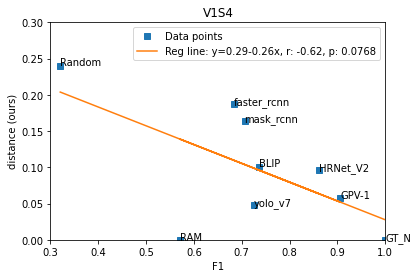

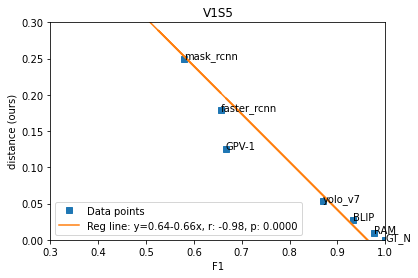

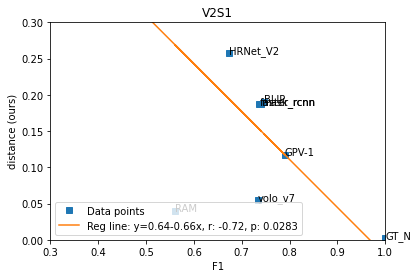

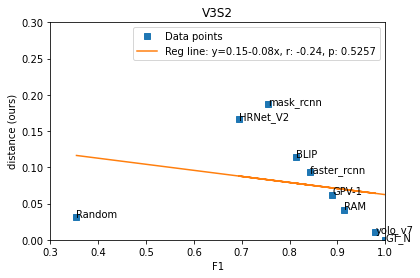

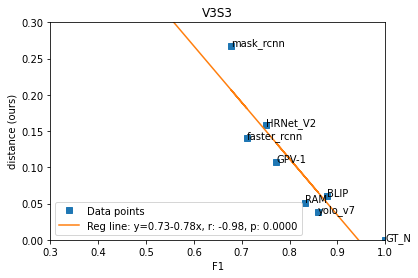

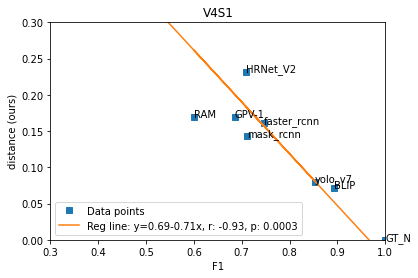

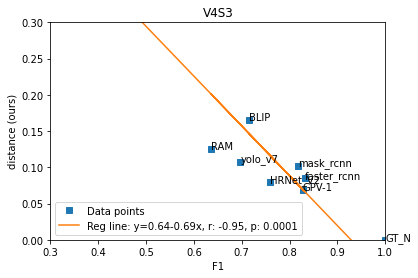

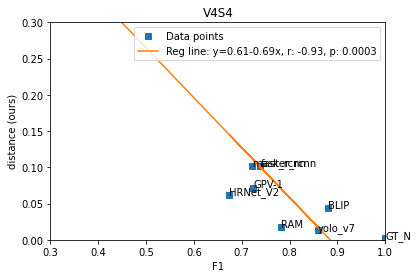

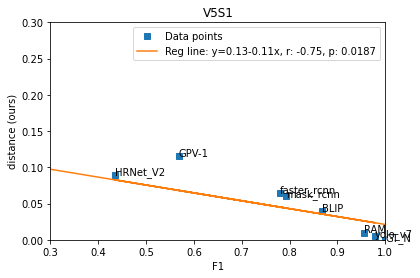

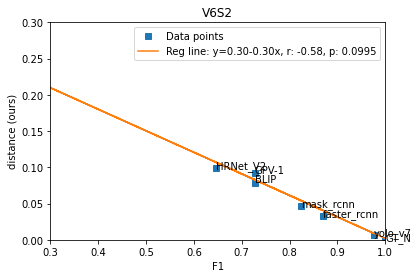

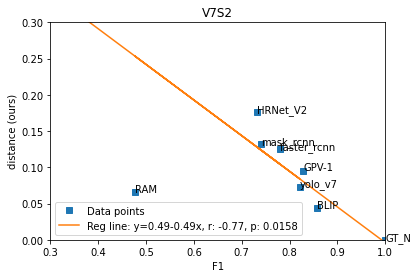

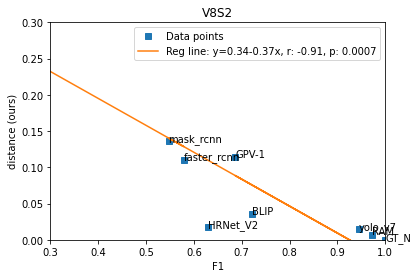

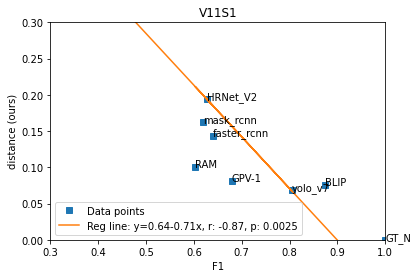

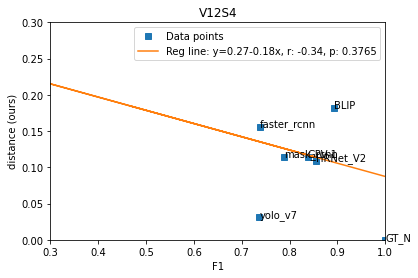

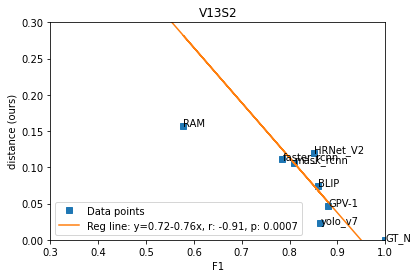

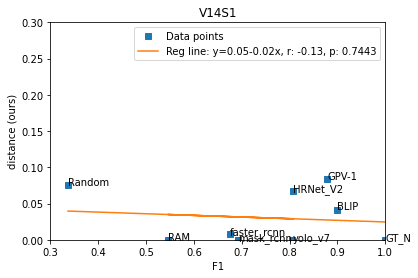

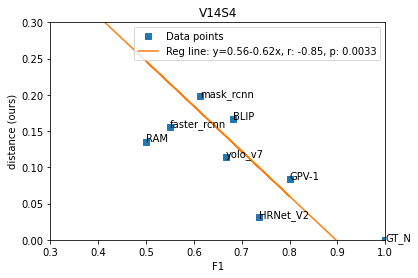

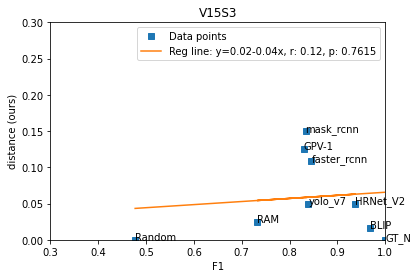

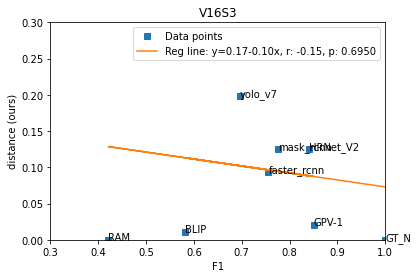

In [42]:
lklhd = {}
v_s_s = [
    'V1S4', 'V1S5', 'V2S1', 'V3S2', 'V3S3', 'V4S1', 'V4S3', 'V4S4', 'V5S1',
    'V6S2', 'V7S2', 'V8S2', 'V11S1', 'V12S4', 'V13S2', 'V14S1', 'V14S4',
    'V15S3', 'V16S3'
]

for v_s__ in v_s_s:
    v_s_ = [v_s__]
    for key in dict(normalized_likelihood_df.mean(axis='columns')):
        if key in ['GT_N (without lpips)']: # , 'GT_N (with lpips)'
            continue
        lklhd[key] = dict(normalized_likelihood_df.reindex(columns=v_s_).mean(axis='columns'))[key]
    
    mF1 = {}
    
    for key in dict(f1_scores_df.mean(axis='columns')):
        if key in ['GT_N (without lpips)']: # , 'GT_N (with lpips)'
            continue
        mF1[key] = dict(f1_scores_df.reindex(columns=v_s_).mean(axis='columns'))[key]
    
    x, y = np.array(list(mF1.values())), np.array(list(lklhd.values()))
    # print("pearson: ", scipy.stats.pearsonr(x, y))
    # print("spearman: ", scipy.stats.spearmanr(x, y))
    # print("kendall: ", scipy.stats.kendalltau(x, y))
    slope, intercept, r, p, stderr = scipy.stats.linregress(x, y)
    line = f'Reg line: y={intercept:.2f}-{abs(slope):.2f}x, r: {r:.2f}, p: {p:.4f}'
    fig, ax = plt.subplots()
    ax.plot(x, y, linewidth=0, marker='s', label='Data points')
    for i, txt in enumerate(mF1.keys()):
        ax.annotate(txt, (x[i], y[i]))
    ax.plot(x, intercept + slope * x, label=line)
    ax.set_xlabel(f'{select}')
    ax.set_ylabel('distance (ours)')
    ax.legend(facecolor='white')
    plt.xlim(0.3, 1.0)
    plt.ylim(0.0, 0.3)
    plt.title(f"{v_s_[0]}")
    plt.savefig(f'/Users/ibk5106/Desktop/research/corr_plots_vtrbi/{v_s__}.png')

In [39]:
def gen_heat_map(gt_path, gt_files, pred_path, obj_list=None, d_s=[]):
    hm_figs = []
    for fl in gt_files:
        if fl in ["video-10-segment-1.csv", "video-9-segment-2.csv"]:
            continue
        gt_fl = os.path.join(gt_path, fl)
        pred_fl = os.path.join(pred_path, fl)

        if not os.path.exists(pred_fl):
            continue

        gt_data = pd.read_csv(gt_fl)
        if limit_frame_count > 0:
            if len(list(gt_data.columns)) > limit_frame_count:
                gt_data = gt_data.iloc[: , :limit_frame_count]
        
        gt_data.replace(-1, 1, inplace=True)

        gt_data = gt_data.transpose()
        gt_data.columns = gt_data.iloc[0]
        gt_data = gt_data.iloc[1:]
        gt_data.columns = gt_data.columns.str.lower()
        if obj_list is not None:
            gt_data = gt_data.reindex(columns=obj_list)
    
        gt_data = gt_data.fillna('0').transpose()
        gt_data.columns = gt_data.columns.str.replace("_", "-")
        gt_data.columns = gt_data.columns.str.capitalize()

        pred_data = pd.read_csv(pred_fl)
        if limit_frame_count > 0:
            if len(list(pred_data.columns)) > limit_frame_count:
                pred_data = pred_data.iloc[: , :limit_frame_count]
            
        pred_data.replace(-1, 1, inplace=True)

        pred_data = pred_data.transpose()
        pred_data.columns = pred_data.iloc[0]
        pred_data = pred_data.iloc[1:]
        pred_data.columns = pred_data.columns.str.lower()
        if obj_list is not None:
            pred_data = pred_data.reindex(columns=obj_list)
    
        pred_data = pred_data.fillna('0').transpose()
        pred_data.columns = pred_data.columns.str.replace("_", "-")
        pred_data.columns = pred_data.columns.str.capitalize()

        hm_ = gt_data.mul(2).add(pred_data.mul(-1), fill_value=0)

        color_tp = 'rgb(71, 137, 209)' 
        color_tn = 'rgb(104, 212, 202)'
        color_fp = 'rgb(202, 121, 59)' 
        color_fn = 'rgb(198, 59, 59)'
        
        fig = go.Figure()
        
        colorscale = [
            [0, color_fp],
            [0.25, color_tn],
            [0.5, color_tp],
            [1, color_fn]
        ]
        
        fig.update_layout(
            template="simple_white",
            xaxis=dict(title_text="Frames", tickmode='linear'),
            yaxis=dict(title_text="Objects",  tickmode='linear'),
            width=1000,
            height=250,
            margin=dict(l=0, r=0, t=10, b=5),
            title=dict(
                text="",
                font=dict(size=16, color="black"),
                x=0.5,
                y=0.995
        
            )
        )
        
        fig.add_trace(
            go.Heatmap(
                z=hm_,
                x=[f'{i} {d_s[i]:.2f}' for i, x in enumerate(list(hm_.columns))],
                y=[x.capitalize() for i, x in enumerate(list(hm_.index))],
                colorscale=colorscale,
                zmin=-1,
                zmax=2
            )
        )


        # fig.add_traces(go.Bar(x=[], y =[], name='TP',
        #                  marker_color=color_tp))
        # fig.add_traces(go.Bar(x=[], y =[], name='FP',
        #                  marker_color=color_fp))
        # fig.add_traces(go.Bar(x=[], y =[], name='TN',
        #                  marker_color=color_tn))
        # fig.add_traces(go.Bar(x=[], y =[], name='FN',
        #                  marker_color=color_fn))
        
        fig.update_layout(
            font_family="Courier New, monospace",
            font_color="black",
            title_font_family="Courier New, monospace",
            title_font_color="black",
            legend_title_font_color="black",
            font=dict(size=14),
        )

        fig.update_traces(
          colorbar_tickmode='array',
          colorbar_ticktext=['FP', 'TN', 'TP', 'FN'],
          colorbar_tickvals=[-1, 0, 1, 2],
          colorbar_tickangle=0,
          selector=dict(type='heatmap')
         )

        fig.update_xaxes(ticklabelposition='outside')
        
        fig.update_xaxes(
            tickson="boundaries",
            ticklen=5,
            tickangle=90
        )
        fig.update_layout(
             xaxis=dict(showgrid=True),
             yaxis=dict(showgrid=True)
        )
        
        fig.update_layout(xaxis=dict(domain=[0, 1]))
        
        hm_figs.append(fig)

    return hm_figs

In [43]:
def gen_heat_map_model_only(gt_path, gt_files, pred_path, obj_list=None, d_s=[]):
    hm_figs = []
    for fl in gt_files:
        if fl in ["video-10-segment-1.csv", "video-9-segment-2.csv"]:
            continue
        gt_fl = os.path.join(gt_path, fl)
        pred_fl = os.path.join(pred_path, fl)

        if not os.path.exists(pred_fl):
            continue

        gt_data = pd.read_csv(gt_fl)
        if limit_frame_count > 0:
            if len(list(gt_data.columns)) > limit_frame_count:
                gt_data = gt_data.iloc[: , :limit_frame_count]
            
        gt_data.replace(-1, 1, inplace=True)

        gt_data = gt_data.transpose()
        gt_data.columns = gt_data.iloc[0]
        gt_data = gt_data.iloc[1:]
        gt_data.columns = gt_data.columns.str.lower()
        if obj_list is not None:
            gt_data = gt_data.reindex(columns=obj_list)
    
        gt_data = gt_data.fillna('0').transpose()
        gt_data.columns = gt_data.columns.str.replace("_", "-")
        gt_data.columns = gt_data.columns.str.capitalize()

        pred_data = pd.read_csv(pred_fl)
        if limit_frame_count > 0:
            if len(list(pred_data.columns)) > limit_frame_count:
                pred_data = pred_data.iloc[: , :limit_frame_count]
            
        pred_data.replace(-1, 1, inplace=True)

        pred_data = pred_data.transpose()
        pred_data.columns = pred_data.iloc[0]
        pred_data = pred_data.iloc[1:]
        pred_data.columns = pred_data.columns.str.lower()
        if obj_list is not None:
            pred_data = pred_data.reindex(columns=obj_list)
    
        pred_data = pred_data.fillna('0').transpose()
        pred_data.columns = pred_data.columns.str.replace("_", "-")
        pred_data.columns = pred_data.columns.str.capitalize()

        hm_ = pred_data # gt_data.mul(2).add(pred_data.mul(-1), fill_value=0)

        color_tp = 'rgb(71, 137, 209)' 
        color_tn = 'rgb(104, 212, 202)'
        color_fp = 'rgb(202, 121, 59)' 
        color_fn = 'rgb(198, 59, 59)'
        color_agreement = 'rgb(6, 200, 115)' # green
        color_disagreement = 'rgb(211, 6, 50)'
        
        fig = go.Figure()
        
        colorscale = [
            [0, color_disagreement],
            [1, color_agreement]
        ]
        
        fig.update_layout(
            template="simple_white",
            xaxis=dict(title_text="Frames", tickmode='linear'),
            yaxis=dict(title_text="Objects",  tickmode='linear'),
            width=1000,
            height=250,
            margin=dict(l=0, r=0, t=10, b=5),
            title=dict(
                text="",
                font=dict(size=16, color="black"),
                x=0.5,
                y=0.995
        
            )
        )
        
        fig.add_trace(
            go.Heatmap(
                z=hm_,
                x=[f'{i} {d_s[i]:.2f}' for i, x in enumerate(list(hm_.columns))],
                y=[x.capitalize() for i, x in enumerate(list(hm_.index))],
                colorscale=colorscale,
                zmin=0,
                zmax=1
            )
        )


        # fig.add_traces(go.Bar(x=[], y =[], name='TP',
        #                  marker_color=color_tp))
        # fig.add_traces(go.Bar(x=[], y =[], name='FP',
        #                  marker_color=color_fp))
        # fig.add_traces(go.Bar(x=[], y =[], name='TN',
        #                  marker_color=color_tn))
        # fig.add_traces(go.Bar(x=[], y =[], name='FN',
        #                  marker_color=color_fn))
        
        fig.update_layout(
            font_family="Courier New, monospace",
            font_color="black",
            title_font_family="Courier New, monospace",
            title_font_color="black",
            legend_title_font_color="black",
            font=dict(size=14),
        )

        fig.update_traces(
          colorbar_tickmode='array',
          colorbar_ticktext=['Disagree', 'Agree'],
          colorbar_tickvals=[0, 1],
          colorbar_tickangle=0,
          selector=dict(type='heatmap')
         )

        fig.update_xaxes(ticklabelposition='outside')
        
        fig.update_xaxes(
            tickson="boundaries",
            ticklen=5,
            tickangle=90
        )
        fig.update_layout(
             xaxis=dict(showgrid=True),
             yaxis=dict(showgrid=True)
        )
        
        fig.update_layout(xaxis=dict(domain=[0, 1]))
        
        hm_figs.append(fig)

    return hm_figs

In [41]:
out_plot_path = './heat_maps_viterbi'
if not os.path.exists(out_plot_path):
    os.makedirs(out_plot_path)

workbook = Workbook()
worksheet = workbook.active

row = 2

pickle_pth = 'all_sims.pickle'

with open(pickle_pth, 'rb') as db_f:
    sim_dict_pkl = pickle.load(db_f)

for mod_ind, model_ in enumerate(models):
    col = 2
    worksheet.row_dimensions[row].height = 195
    worksheet.cell(row=row, column=1).value = model_
    worksheet.cell(row=row, column=1).alignment = Alignment(horizontal='center', vertical='center')

    for gt in gts:    
        v_ = int(gt.split('-')[1])
        s_ = int(gt.split('-')[3])
        
        if mod_ind == 0:
            worksheet.cell(row=1, column=col).value = f'Video {v_} Segment {s_}'
            worksheet.cell(row=1, column=col).alignment = Alignment(horizontal='center', vertical='center')
            
        f1_s_xl = f1_scores_df[f'V{v_}S{s_}'][model_]
        lh_s_xl = normalized_likelihood_df[f'V{v_}S{s_}'][model_]
        td_s_xl = temporal_dist_df[f'V{v_}S{s_}'][model_]

        d_i_s = [0] + list(sim_dict_pkl[gt].values())

        hm_p = gen_heat_map(
            gt_fol, [f'{gt}.csv'], os.path.join(data_path, model_), 
            obj_list=all_com, d_s=d_i_s
        )[0]
        hm_p.update_layout(
            title=dict(text=f"F1={f1_s_xl}, dist={lh_s_xl}, temp={td_s_xl}", font=dict(size=16), automargin=True, yref='paper')
        )

        img_out_name = os.path.join(out_plot_path, f'{model_}_v{v_}s{s_}_F1_{f1_s_xl}_dist_{lh_s_xl}_temp_{td_s_xl}.png')

        hm_p.write_image(
            img_out_name,
            format='png'
        )

        worksheet.column_dimensions[get_column_letter(col)].width = 128

        anchor = f'{get_column_letter(col)}{row}'
        # worksheet.add_image(Image_openpyxl(img_out_name), anchor=anchor)
        img = Image_openpyxl(img_out_name) 

        worksheet.add_image(img, anchor=anchor)
    
        col = col + 1
        
    row = row + 1

workbook.save('investigate_entropy_viterbi.xlsx')

In [44]:
out_plot_path = './heat_maps_viterbi_model_only'
if not os.path.exists(out_plot_path):
    os.makedirs(out_plot_path)

workbook = Workbook()
worksheet = workbook.active

row = 2

pickle_pth = 'all_sims.pickle'

with open(pickle_pth, 'rb') as db_f:
    sim_dict_pkl = pickle.load(db_f)

for mod_ind, model_ in enumerate(models):
    col = 2
    worksheet.row_dimensions[row].height = 195
    worksheet.cell(row=row, column=1).value = model_
    worksheet.cell(row=row, column=1).alignment = Alignment(horizontal='center', vertical='center')

    for gt in gts:    
        v_ = int(gt.split('-')[1])
        s_ = int(gt.split('-')[3])
        
        if mod_ind == 0:
            worksheet.cell(row=1, column=col).value = f'Video {v_} Segment {s_}'
            worksheet.cell(row=1, column=col).alignment = Alignment(horizontal='center', vertical='center')
            
        f1_s_xl = f1_scores_df[f'V{v_}S{s_}'][model_]
        lh_s_xl = normalized_likelihood_df[f'V{v_}S{s_}'][model_]
        td_s_xl = temporal_dist_df[f'V{v_}S{s_}'][model_]

        d_i_s = [0] + list(sim_dict_pkl[gt].values())

        hm_p = gen_heat_map_model_only(
            gt_fol, [f'{gt}.csv'], os.path.join(data_path, model_), 
            obj_list=all_com, d_s=d_i_s
        )[0]
        hm_p.update_layout(
            title=dict(text=f"F1={f1_s_xl}, dist={lh_s_xl}, temp={td_s_xl}", font=dict(size=16), automargin=True, yref='paper')
        )

        img_out_name = os.path.join(out_plot_path, f'{model_}_v{v_}s{s_}_F1_{f1_s_xl}_dist_{lh_s_xl}_temp_{td_s_xl}.png')

        hm_p.write_image(
            img_out_name,
            format='png'
        )

        worksheet.column_dimensions[get_column_letter(col)].width = 128

        anchor = f'{get_column_letter(col)}{row}'
        # worksheet.add_image(Image_openpyxl(img_out_name), anchor=anchor)
        img = Image_openpyxl(img_out_name) 

        worksheet.add_image(img, anchor=anchor)
    
        col = col + 1
        
    row = row + 1

workbook.save('investigate_entropy_viterbi_model_only.xlsx')

In [68]:
import sys
import numpy as np

# Example 1: Find maximum float value 
# Using sys.float_info
max_float_value = sys.float_info.max
min_float_value = sys.float_info.min


In [69]:
max_float_value, min_float_value

(1.7976931348623157e+308, 2.2250738585072014e-308)

In [21]:
import numpy as np
from sklearn.metrics import average_precision_score, precision_score
y_true = np.array([0, 0, 1, 1])
y_scores = np.array([0.1, 0.3, 0.3, 0.8])
average_precision_score(y_true, y_scores)

0.8333333333333333

In [59]:
# y_true = np.array([0, 0, 1, 1, 2, 2])
y_true = np.array([
    [1, 0, 1], 
    [1, 1, 0], 
    [0, 0, 0], 
    [1, 1, 0], 
    [0, 1, 1], 
    [0, 1, 1]
])
y_scores = np.array([
    [1, 0, 1], 
    [1, 0, 0], 
    [0, 0, 0], 
    [1, 0, 0], 
    [0, 0, 1], 
    [0, 0, 0]
])
average_precision_score(y_true, y_scores, average=None)

array([1.        , 0.66666667, 0.83333333])

In [62]:
y_true = np.array([
    [1, 0, 1], 
    [1, 1, 0], 
    [0, 0, 0], 
    [1, 1, 0], 
    [0, 1, 1], 
    [0, 1, 1]
])
y_scores = np.array([
    [1, 0, 1], 
    [1, 0, 0], 
    [0, 0, 1], 
    [1, 0, 0], 
    [0, 0, 1], 
    [0, 0, 0]
])
precision_score(y_true, y_scores, average=None)

/Users/ibk5106/anaconda3/envs/conda_pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([1.        , 0.        , 0.66666667])

In [53]:
import math

# Coordinates in degrees
lat_A = 40.812841
lon_A = -119


lat_B = 21.4224829
lon_B = 39.8236973

# Convert degrees to radians
phi_1 = lat_A * math.pi / 180
phi_2 = lat_B * math.pi / 180
delta_lambda = (lon_B - lon_A) * math.pi / 180

# Calculate true bearing in radians
true_bearing_rad = math.atan2(math.sin(delta_lambda) * math.cos(phi_2),
                              math.cos(phi_1) * math.sin(phi_2) - math.sin(phi_1) * math.cos(phi_2) * math.cos(delta_lambda))

# Convert radians to degrees
true_bearing_deg = true_bearing_rad * 180 / math.pi

print("True Bearing (degrees):", true_bearing_deg)

True Bearing (degrees): 21.729300831382275
